# Notebook for phase diagram for hetergeneous model

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook
from ternary.helpers import simplex_iterator
import ternary
from scipy.special import comb, perm
from sparseness_expansion import *
#from heterogeneous_model import *

## Copy functions

In [118]:
def generate_hetergeneous(H,N,P,K,p1,p2,p3,d_stim,d_cont):
    """
    Generates mixed layer activations of a heterogeneous mixing 
    """
    N1 = int(p1*H)
    N2 = int(p2*H)
    N3 = int(p3*H)
    
    
    ### Produce stimuli and contextual inputs
    stim = make_patterns(N,P)
    cont = make_patterns(N,K)
    
    stim_test = make_patterns(N,P)
    cont_test = make_patterns(N,K)
    stim_comp_test = np.zeros((2*N,int(P*K)))
    
    ### Generate test patterns - flip all
    for p in range(P):
        stim_test[:,p] = flip_patterns_cluster(stim[:,p],d_stim)
    for k in range(K):
        cont_test[:,k] = flip_patterns_cluster(cont[:,k],d_cont)
    
    # plt.figure()
    # plt.imshow(stim)
    # plt.show()
    
    
    # Flip mixed one
    count0 = 0
    for p in range(P):
        stim_t_flip = flip_patterns_cluster(stim[:,p],d_stim)

        
        for k in range(K):
            cont_t_flip = flip_patterns_cluster(cont[:,k],d_cont)
            
            stim_comp_test[:,count0] = np.concatenate((stim_t_flip,cont_t_flip),axis=0)
            count0 += 1
            
        
    
    ### Generate three separate weight matrices
    mat1 = np.random.normal(0,1/np.sqrt(N),(N1,N))
    mat2 = np.random.normal(0,1/np.sqrt(N),(N2,N))
    
    mat3a = np.random.normal(0,1/np.sqrt(2*N),(N3,N))
    mat3b = np.random.normal(0,1/np.sqrt(2*N),(N3,N)) #Same prob, but different matrix. Normalized accordingly

    ### Plot composite pattern
    # plt.figure()
    # plt.imshow(stim_comp_test[:N])
    # plt.show()
    
    ### Initialize heterogeneous mixed layer activities - three separate matrices
    h1 = np.zeros((N1,P*K))
    h2 = np.zeros((N2,P*K))
    h3 = np.zeros((N3,P*K))
    
    # Same for test
    h1_test = np.zeros((N1,P*K))
    h2_test = np.zeros((N2,P*K))
    h3_test = np.zeros((N3,P*K))
    
    
    ### Fill in all entries - number of columns should be P*K
    
    ## for each pattern p
    count=0
    hcont_in = np.zeros((N2,K))
    hcont_in_t = np.zeros((N2,K))
    for p in range(P):
    # generate K times the pattern --> h_aug1
        h_stim = np.matmul(mat1,stim[:,p])
        #print("shape",h_stim.shape)
        h_aug1 = np.tile(h_stim,(K,1)).T
    
        h_stim_t = np.matmul(mat1,stim_test[:,p])
        h_aug1_t = np.tile(h_stim_t,(K,1)).T
        
        #Get h_stim for below
        h_stim_comb = np.matmul(mat3a,stim[:,p])
        h_stim_comb_t = np.matmul(mat3a,stim_test[:,p])
        
        h1[:,p*K : (p+1)*K] = h_aug1
        h1_test[:,p*K : (p+1)*K] = h_aug1_t
    
        ##for each context k
        for k in range(K):
            #get h_cont
            h_cont = np.matmul(mat2,cont[:,k])
            hcont_in[:,k] = h_cont
            
            h_cont_t = np.matmul(mat2,cont_test[:,k])
            hcont_in_t[:,k] = h_cont_t
            
            
            #Get h_cont for mixed
            h_cont_comb = np.matmul(mat3b,cont[:,k])
            h_cont_comb_t = np.matmul(mat3b,cont_test[:,k])
            
            #get h_comb = h_stim + h_cont
            h_comb = h_stim_comb + h_cont_comb
            h3[:,count] = h_comb
            
            h_comb_t = h_stim_comb_t + h_cont_comb_t
            h3_test[:,count] = h_comb_t
            count += 1
    
    #Repeat hcont_in P times
    h_cont_rep = np.tile(hcont_in,(1,P))
    h2 = h_cont_rep
    
    h_cont_rep_t = np.tile(hcont_in_t,(1,P))
    h2_test = h_cont_rep_t
    
    ### Join all h's row wise
    conc1 = np.vstack((h1,h2))
    h_out = np.vstack((conc1,h3))
    
    conc1_t = np.vstack((h1_test,h2_test))
    h_out_test = np.vstack((conc1_t,h3_test))
    
    
    return h_out, h_out_test

def genOutApplyNonlinearity(H,N,P,K,p1,p2,p3,th,ds,dc):
    
        
    h, h_test = generate_hetergeneous(H,N,P,K,p1,p2,p3,d_stim=ds,d_cont=dc)
    
    f = erf1(th)
    
    m = 0.5*(np.sign(h - th) + 1) - f
    m_test = 0.5*(np.sign(h_test - th) + 1) - f
    
    return m, m_test

def genOutApplyNonlinearityUnimod(H,N,P,th,ds):
    
    stim = make_patterns(N,P)
    len_test = P
    patts_test = np.zeros((N,len_test))
    ##CREATE TEST PATTERNS
    for n in range(len_test):#Pick test points - perturb ONE pattern randomly
        patt_typ = stim[:,n]
        patt_test = flip_patterns_cluster(patt_typ,ds)
        d_in_check = compute_delta_out(patt_test,patt_typ)
        patts_test[:,n] = patt_test

    h,h_test = random_proj_generic_test(H,stim,patts_test,th)
    
    f = erf1(th)
    
    m = 0.5*(np.sign(h) + 1) - f
    m_test = 0.5*(np.sign(h_test) + 1) - f
    
    return m, m_test


def compute_delta_m_theory_het(ds,dc,p1,p2,p3,th):
    d_eff = 0.5*ds + 0.5*dc
    cod = erf1(th)
    size1 = p1 * erf_full(th,ds,cod)
    size2 = p2 * erf_full(th,dc,cod)
    size3 = p3 * erf_full(th,d_eff,cod)
    return size1 + size2 + size3

In [119]:
gaussian_func_2dim_onehalf = lambda y,x: (1/(2*np.pi))*np.exp(-(1./2)*(x**(2) + y**(2)))

def two_dim_integral_thres(t_in):
    """
    Parameters
    ----------
    t_phi : Either t_phi or t_xi 

    """
    res = integrate.dblquad(gaussian_func_2dim_onehalf, t_in, np.inf, lambda x: th, lambda x: np.inf)
    return res[0]

def func_3dim(x,y,p):
    exp_ = np.exp(-(1./2)*(x**(2) + y**(2)) + p*x*y)
    denom = (1/(2*np.pi))
    return denom * exp_

def func_3dim_g(x,y,p):
    exp_ = x*y*np.exp(-(1./2)*(x**(2) + y**(2)) + p*x*y)
    denom = (1/(2*np.pi))
    return denom * exp_

def two_dim_i_integral(t_in,p):
    """
    Parameters
    ----------
    t_in : Either t_phi or t_xi 
    p: Peak 

    """
    res = integrate.dblquad(func_3dim, t_in, np.inf, lambda x: t_in, lambda x: np.inf,args=(p,))
    return res[0]

def two_dim_g_integral(t_in,p):
    """
    Parameters
    ----------
    t_in : Either t_phi or t_xi 
    p: Peak 

    """
    res = integrate.dblquad(func_3dim_g, t_in, np.inf, lambda x: t_in, lambda x: np.inf,args=(p,))
    return res[0]

In [120]:
def hebbian_mixed_layer_heterogeneous(H,N,P,K,th,p1,p2,p3,ds=0.1,dc=0.):
    """
    comp_num: True if want to compare "numerical theory" to theory
    """
    n_real = 20
    errors = np.zeros(n_real)
    Peff = P*K
    #Peff=P
    len_test = int(Peff)
    erf = erf1(th)
    for j in range(n_real):
        labels = np.zeros(int(Peff))
        for i in range(int(Peff)):
            labels[i] = make_labels(0.5)
            
        o_in, o_test_in = genOutApplyNonlinearity(H,N,P,K,p1,p2,p3,th,ds,dc)
        
        #o_in, o_test_in = genOutApplyNonlinearityUnimod(H,N,P,th,ds)
        
        w_hebb = np.matmul(o_in,labels) 
        stabs = []
        d_outs = []
        acts_typ = np.zeros((H,len_test))
        labels_test = labels
        
        for m in range(len_test):
            stab = labels_test[m]*np.dot(w_hebb,o_test_in[:,m])
            stabs.append(stab)
            d_out = (1/(2*erf*(1-erf))) * compute_delta_out(o_test_in[:,m],o_in[:,m])
            d_outs.append(d_out)
            #print("d_out is",d_out)
            acts_typ[:,m] = o_in[:,m]
        
        #print("stabilities",stab)
        err = (len(np.where(np.asarray(stabs)<0)[0]))/(len(stabs))
        errors[j] = err
            
    err_mean = np.mean(errors)
    err_std = np.std(errors)
    
    d_out_mean = np.mean(d_outs)
    print("d_out is",d_out_mean)
    
    d_theory = compute_delta_m_theory_het(ds,dc,p1,p2,p3,th)
    d_theory_out = d_theory
    print("d_out theory",d_theory)
    
    d_theory1 = (1 - erf_full(th,ds,erf))

    diff = 1 - d_theory_out
    numer = diff**(2)
    
    numer1 = (d_theory1)**(2)
    
    alpha = Peff/H
    
    #Get effective qtheory
    f_one_minus = erf*(1-erf) #erf = f 
    
    #Probabilities in theory
    q1 = (K-1)/(Peff-1)
    q2 = (P-1)/(Peff-1)
    
    #Peaks
    p_xi = (1/2)*(1 - ds)
    p_phi = (1/2)*(1 - dc)
    
    #Thresholds
    sqrt_xi = np.sqrt(1 - p_xi**(2))
    sqrt_phi = np.sqrt(1 - p_phi**(2))
    t_xi = th/(sqrt_xi)
    t_phi = th/(sqrt_phi)
    print("thresholds",t_phi,t_xi)
    
    size1 = erf_full(th,ds,erf)
    size2 = erf_full(th,dc,erf)
    ds_eff = 0.5*(ds + dc)
    size3 = erf_full(th,ds_eff,erf)
    
    #Get G functions
    g_func_generic = (1/(2*np.pi)) * np.exp(-th**(2))
    #g_func_xi = (1/(2*np.pi)) * np.exp(-t_xi**(2))
    #g_func_phi = (1/(2*np.pi)) * np.exp(-t_phi**(2))
    
    g_func_xi = two_dim_g_integral(t_xi,p_xi)
    g_func_phi = two_dim_g_integral(t_phi,p_phi)
    
    eo_xi =  (1/N)*excess_over_theory(th,erf)**(2)
    eo_phi = eo_xi
    eo_t_phi = (1/(4*N)) * g_func_phi**(2)
    eo_t_xi = (1/(4*N)) * g_func_xi**(2)
    eo_cross = (1/((2*np.pi)**(2))) * (np.exp(-2*th**(2))) * (1/N)
    eo_sqrt_phi_inter = (1/(2*N)) * np.exp(-th**(2)) * g_func_phi
    eo_sqrt_xi_inter = (1/(2*N)) * np.exp(-th**(2)) * g_func_xi
    eo_cross_inter = (1/(2*N)) * (1/((2*np.pi)**(2))) * (np.exp(-2*th**(2)))
    
    f=erf
    
    #Get the two dimensional integrals
    i_phi = two_dim_i_integral(t_phi,p_phi)
    i_xi = two_dim_i_integral(t_xi,p_xi)
    
    
    #Get the R functions -- > this comes from Eq. 15
    r_xi = f_one_minus*(1-size1)
    r_phi = f_one_minus*(1-size2)
    r_mixed = (q1)*(sqrt_xi)*(i_xi) + (q2)*(sqrt_phi)*(i_phi)  + (1-q1-q2)*f**(2)


    part3_one = (2*f**(3) - 3*f**(4))/(f_one_minus**(2))
    part3_xi = (1/(f_one_minus**(2)))*p1*r_xi*q1
    part3_phi = (1/(f_one_minus**(2)))*p2*q2*r_phi
    part3_mixed = (1/(f_one_minus**(2)))*p3*r_mixed
    part3 = (Peff/H)*(part3_one + (2*f - 1)**(2) * (part3_xi + part3_phi + part3_mixed)) #H = N_{c}
    print("part3",part3)
    
    #Terms for intra part
    part4_xi_1 = ((1/f_one_minus)*r_xi*p1)**(2) * q1
    part4_xi_eo = (p1)**(2) * eo_xi * (1-q1)
    part4_phi_1 = ((1/f_one_minus)*r_phi*p2)**(2) * q2
    part4_phi_eo = (p2)**(2) * eo_phi * (1-q2)
    
    #Part 4 intra for mixed terms
    part4_mixed_four_pt = (q1)*((sqrt_xi*i_xi)**(2) + eo_t_xi) + (q2)*((sqrt_phi*i_phi)**(2) +  eo_t_phi) \
                             + (1 - q1 - q2)*(f**(4) + eo_cross)
    part4_mixed = p3**(2) * (part4_mixed_four_pt - 2*f**(2) * r_mixed + f**(4)) * (1/f_one_minus)**(2)
    
    i4_intra = Peff * (part4_xi_1 + part4_xi_eo + part4_phi_1 + part4_phi_eo + part4_mixed)
    print("i4 intra",i4_intra) 
    
    ##Terms for inter part
    part4_one_three = q1*(r_xi + f**(2))*sqrt_xi*(i_xi)  + \
        (q2)*(f**(2) * sqrt_phi * (i_phi) + sqrt_phi*eo_sqrt_phi_inter) + (1-q1-q2)*(f**(4) + eo_cross_inter)\
        - f**(2) * (q1*r_xi + r_mixed)
    #part4_one_three = 0
    #print("part4_1_3_parts",part4_one_three + f**(2) * (q1*r_xi + r_mixed),f**(2) * (q1*r_xi + r_mixed))
    part4_two_three = q2*(r_phi + f**(2))*sqrt_phi*(i_phi)  + \
        (q1)*(f**(2) * sqrt_xi * (i_xi) + sqrt_xi*eo_sqrt_xi_inter) + (1-q1-q2)*(f**(4) + eo_cross_inter)\
        - f**(2) * (q2*r_phi + r_mixed)
    #part4_two_three = 0
    print("part 4's",part4_one_three,part4_two_three)
    part4_one_two = q1*q2*(r_xi*r_phi)
    
    part4_full = (1/f_one_minus)**(2) * (2*p1*p2*part4_one_two + 2*p1*p3*part4_one_three + 2*p2*p3*part4_two_three)
    i4_inter = Peff * part4_full
    print("i4 inter",i4_inter)

    denom2 = part3 + i4_intra + i4_inter #Peff = PK
    
    denom2_one = P/H + (P/N) * excess_over_theory(th,f)**(2)
    
    snr = (numer)/(denom2)
    
    snr1 = (numer1)/(denom2_one)
    
    err_theory = erf1(snr**(0.5))
    
    err_theory1 = erf1(snr1**(0.5))
    
    return err_theory, err_mean

In [121]:
def func_het_mixing_theory(H,N,P,K,th,p1,p2,p3,ds=0.1,dc=0.):
    """Just to get theoretical error"""
    Peff = int(P*K)
    erf = erf1(th)
    d_theory = compute_delta_m_theory_het(ds,dc,p1,p2,p3,th)
    d_theory_out = d_theory
    print("d_out theory",d_theory)

    diff = 1 - d_theory_out
    numer = diff**(2)
    
    alpha = Peff/H
    
    #Get effective qtheory
    f_one_minus = erf*(1-erf) #erf = f 
    
    #Probabilities in theory
    q1 = (K-1)/(Peff-1)
    q2 = (P-1)/(Peff-1)
    
    #Peaks
    p_xi = (1/2)*(1 - ds)
    p_phi = (1/2)*(1 - dc)
    
    #Thresholds
    sqrt_xi = np.sqrt(1 - p_xi**(2))
    sqrt_phi = np.sqrt(1 - p_phi**(2))
    t_xi = th/(sqrt_xi)
    t_phi = th/(sqrt_phi)
    print("thresholds",t_phi,t_xi)
    
    size1 = erf_full(th,ds,erf)
    size2 = erf_full(th,dc,erf)
    ds_eff = 0.5*(ds + dc)
    size3 = erf_full(th,ds_eff,erf)
    
    #Get G functions
    g_func_generic = (1/(2*np.pi)) * np.exp(-th**(2))
    #g_func_xi = (1/(2*np.pi)) * np.exp(-t_xi**(2))
    #g_func_phi = (1/(2*np.pi)) * np.exp(-t_phi**(2))
    
    g_func_xi = two_dim_g_integral(t_xi,p_xi)
    g_func_phi = two_dim_g_integral(t_phi,p_phi)
    
    eo_xi =  (1/N)*excess_over_theory(th,erf)**(2)
    eo_phi = eo_xi
    eo_t_phi = (1/(4*N)) * g_func_phi**(2)
    eo_t_xi = (1/(4*N)) * g_func_xi**(2)
    eo_cross = (1/((2*np.pi)**(2))) * (np.exp(-2*th**(2))) * (1/N)
    eo_sqrt_phi_inter = (1/(2*N)) * np.exp(-th**(2)) * g_func_phi
    eo_sqrt_xi_inter = (1/(2*N)) * np.exp(-th**(2)) * g_func_xi
    eo_cross_inter = (1/(2*N)) * (1/((2*np.pi)**(2))) * (np.exp(-2*th**(2)))
    
    f=erf
    
    #Get the two dimensional integrals
    i_phi = two_dim_i_integral(t_phi,p_phi)
    i_xi = two_dim_i_integral(t_xi,p_xi)
    
    
    #Get the R functions -- > this comes from Eq. 15
    r_xi = f_one_minus*(1-size1)
    r_phi = f_one_minus*(1-size2)
    r_mixed = (q1)*(sqrt_xi)*(i_xi) + (q2)*(sqrt_phi)*(i_phi)  + (1-q1-q2)*f**(2)


    part3_one = (2*f**(3) - 3*f**(4))/(f_one_minus**(2))
    part3_xi = (1/(f_one_minus**(2)))*p1*r_xi*q1
    part3_phi = (1/(f_one_minus**(2)))*p2*q2*r_phi
    part3_mixed = (1/(f_one_minus**(2)))*p3*r_mixed
    part3 = (Peff/H)*(part3_one + (2*f - 1)**(2) * (part3_xi + part3_phi + part3_mixed)) #H = N_{c}
    print("part3",part3)
    
    #Terms for intra part
    part4_xi_1 = ((1/f_one_minus)*r_xi*p1)**(2) * q1
    part4_xi_eo = (p1)**(2) * eo_xi * (1-q1)
    part4_phi_1 = ((1/f_one_minus)*r_phi*p2)**(2) * q2
    part4_phi_eo = (p2)**(2) * eo_phi * (1-q2)
    
    #Part 4 intra for mixed terms
    part4_mixed_four_pt = (q1)*((sqrt_xi*i_xi)**(2) + eo_t_xi) + (q2)*((sqrt_phi*i_phi)**(2) +  eo_t_phi) \
                             + (1 - q1 - q2)*(f**(4) + eo_cross)
    part4_mixed = p3**(2) * (part4_mixed_four_pt - 2*f**(2) * r_mixed + f**(4)) * (1/f_one_minus)**(2)
    
    i4_intra = Peff * (part4_xi_1 + part4_xi_eo + part4_phi_1 + part4_phi_eo + part4_mixed)
    print("i4 intra",i4_intra) 
    
    ##Terms for inter part
    part4_one_three = q1*(r_xi + f**(2))*sqrt_xi*(i_xi)  + \
        (q2)*(f**(2) * sqrt_phi * (i_phi) + sqrt_phi*eo_sqrt_phi_inter) + (1-q1-q2)*(f**(4) + eo_cross_inter)\
        - f**(2) * (q1*r_xi + r_mixed)
    #part4_one_three = 0
    #print("part4_1_3_parts",part4_one_three + f**(2) * (q1*r_xi + r_mixed),f**(2) * (q1*r_xi + r_mixed))
    part4_two_three = q2*(r_phi + f**(2))*sqrt_phi*(i_phi)  + \
        (q1)*(f**(2) * sqrt_xi * (i_xi) + sqrt_xi*eo_sqrt_xi_inter) + (1-q1-q2)*(f**(4) + eo_cross_inter)\
        - f**(2) * (q2*r_phi + r_mixed)
    #part4_two_three = 0
    print("part 4's",part4_one_three,part4_two_three)
    part4_one_two = q1*q2*(r_xi*r_phi)
    
    part4_full = (1/f_one_minus)**(2) * (2*p1*p2*part4_one_two + 2*p1*p3*part4_one_three + 2*p2*p3*part4_two_three)
    i4_inter = Peff * part4_full
    print("i4 inter",i4_inter)

    denom2 = part3 + i4_intra + i4_inter #Peff = PK
    
    snr = (numer)/(denom2)
    
    err_theory = erf1(snr**(0.5))
    
    return err_theory

## 1. Try for a few parameter choices

### 1a).$\Delta \xi = 0.3, \Delta \phi = 0.3, P =5, K =5$ 

In [83]:
N=100
H=2100
P=5
K=5
d_xi=0.3
d_phi=0.3
th=2.8

In [84]:
n=10 # grid size
def func_run_grid_sim(n,N,H,P,K,d_xi,d_phi,th):
    Record_2= dict()


    for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):

        p1 = i / float(n)
        p2 = j / float(n)
        p3 = k / float(n)

        Record_2[(i,j,k)] = hebbian_mixed_layer_heterogeneous(H,N,P,K,th,p1,p2,p3,ds=d_xi,dc=d_phi)[0]
        
    return Record_2

In [85]:
Record_2 = func_run_grid_sim(n,N,H,P,K,d_xi,d_phi,th)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


d_out is 0.8295865786089803
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.060948617677749645
i4 intra 0.012235161502850358
part 4's 7.025627415125471e-09 7.025627415125471e-09
i4 inter 0.0
d_out is 0.8109021962078774
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.06980768967400416
i4 intra 0.011479613185382728
part 4's 7.025627415125471e-09 7.025627415125471e-09
i4 inter 0.00486736272571166
d_out is 0.8295865786089804
d_out theory 0.8060181487509083
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.07866676167025868
i4 intra 0.01410703283411998
part 4's 7.025627415125471e-09 7.025627415125471e-09
i4 inter 0.008653089290154063
d_out is 0.7810071843661122
d_out theory 0.806018148750908
thresholds 2.989058871028293 2.9

d_out is 0.8781659728518487
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.13182119364778574
i4 intra 0.06325470118307149
part 4's 7.025627415125471e-09 7.025627415125471e-09
i4 inter 0.01492458239249153
d_out is 0.9342191200551582
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.14068026564404024
i4 intra 0.08328636712294717
part 4's 7.025627415125471e-09 7.025627415125471e-09
i4 inter 0.012184104678438702
d_out is 0.9342191200551581
d_out theory 0.8060181487509083
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.14953933764029476
i4 intra 0.10670100102902773
part 4's 7.025627415125471e-09 7.025627415125471e-09
i4 inter 0.008361990803116625
d_out is 0.7623228019650091
d_out theory 0.806018148750908
thresholds 2.98905

d_out is 0.7286909136430235
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.14068026564404024
i4 intra 0.07073330817835563
part 4's 7.025627415125471e-09 7.025627415125471e-09
i4 inter 0.01427460237921786
d_out is 0.8594815904507455
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.14953933764029473
i4 intra 0.0815948831398447
part 4's 7.025627415125471e-09 7.025627415125471e-09
i4 inter 0.01254298620467493
d_out is 0.8520078374903042
d_out theory 0.806018148750908
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.12296212165153121
i4 intra 0.07798865057087945
part 4's 7.025627415125471e-09 7.025627415125471e-09
i4 inter 0.011357179693327207
d_out is 0.915534737654055
d_out theory 0.806018148750908
thresholds 2.989058871

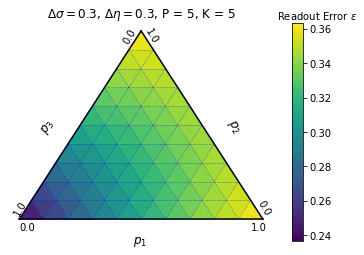

In [86]:
figure, tax = ternary.figure(scale=n)
tax.heatmap(Record_2,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(10.6,9.2,r'Readout Error $\epsilon$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \xi = 0.3$, $\Delta \phi = 0.3$, P = 5, K = 5',y=1)

### 1b).$\Delta \xi = 0.4, \Delta \phi = 0.1, P =5, K =5$ 

In [141]:
N=100
H=2100
P=5
K=5
d_xi=0.4
d_phi=0.1
th=2.8

In [142]:
Record_3 = func_run_grid_sim(n,N,H,P,K,d_xi,d_phi,th)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


d_out is 0.6614271369990519
d_out theory 0.7577628672093383
thresholds 3.135398061352784 2.935197542821371
part3 0.07362837443696023
i4 intra 0.024409799971962503
part 4's 3.689200789650108e-09 2.976791637127861e-08
i4 inter 0.0
d_out is 0.6016371133155218
d_out theory 0.7343019473190373
thresholds 3.135398061352784 2.935197542821371
part3 0.10301642563920947
i4 intra 0.029247464738517165
part 4's 3.689200789650108e-09 2.976791637127861e-08
i4 inter 0.020623246580899965
d_out is 0.8183759491683185
d_out theory 0.7108410274287363
thresholds 3.135398061352784 2.935197542821371
part3 0.1324044768414587
i4 intra 0.053524379026966155
part 4's 3.689200789650108e-09 2.976791637127861e-08
i4 inter 0.03666354947715549
d_out is 0.6128477427561837
d_out theory 0.6873801075384353
thresholds 3.135398061352784 2.935197542821371
part3 0.16179252804370792
i4 intra 0.09724054283730948
part 4's 3.689200789650108e-09 2.976791637127861e-08
i4 inter 0.04812090868876657
d_out is 0.7473752960441266
d_out the

d_out is 0.6576902605188315
d_out theory 0.6998425282694015
thresholds 3.135398061352784 2.935197542821371
part3 0.1974274391685006
i4 intra 0.15944331178958338
part 4's 3.689200789650108e-09 2.976791637127861e-08
i4 inter 0.03978857422887888
d_out is 0.65021650755839
d_out theory 0.6763816083791006
thresholds 3.135398061352784 2.935197542821371
part3 0.22681549037074983
i4 intra 0.2435025626420331
part 4's 3.689200789650108e-09 2.976791637127861e-08
i4 inter 0.036787427095449195
d_out is 0.65021650755839
d_out theory 0.6529206884887996
thresholds 3.135398061352784 2.935197542821371
part3 0.25620354157299907
i4 intra 0.3470010630163771
part 4's 3.689200789650108e-09 2.976791637127861e-08
i4 inter 0.029203336277375064
d_out is 0.6539533840386107
d_out theory 0.6294597685984985
thresholds 3.135398061352784 2.935197542821371
part3 0.28559159277524826
i4 intra 0.4699388129126156
part 4's 3.689200789650108e-09 2.976791637127861e-08
i4 inter 0.017036301774656495
d_out is 0.8370603315694217
d

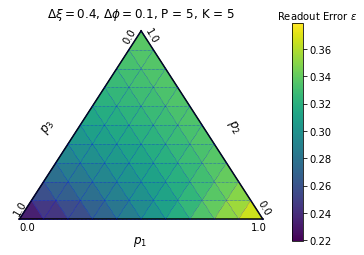

In [143]:
figure, tax = ternary.figure(scale=n)
tax.heatmap(Record_3,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(10.6,9.2,r'Readout Error $\epsilon$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \xi = 0.4$, $\Delta \phi = 0.1$, P = 5, K = 5',y=1)

### 1c).$\Delta \xi = 0.3, \Delta \phi = 0.3, P =80, K =5$ 

In [90]:
N=100
H=2100
P=80
K=5
d_xi=0.3
d_phi=0.3
th=2.8

In [91]:
Record_4 = func_run_grid_sim(n,N,H,P,K,d_xi,d_phi,th)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


d_out is 0.8034284432474359
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.6801772466154965
i4 intra 0.12307644627657145
part 4's 8.093716894473635e-10 7.974214296918155e-09
i4 inter 0.0
d_out is 0.8461689679899593
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.8963783790150665
i4 intra 0.1295126903719621
part 4's 8.093716894473635e-10 7.974214296918155e-09
i4 inter 0.08839271687444192
d_out is 0.6838483958803756
d_out theory 0.8060181487509083
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 1.1125795114146362
i4 intra 0.19805200116876273
part 4's 8.093716894473635e-10 7.974214296918155e-09
i4 inter 0.15714260777678568
d_out is 0.6719371020996724
d_out theory 0.806018148750908
thresholds 2.989058871028293 2.989058871

f is 0.00255513033042793
cod is 0.00255513033042793
part3 1.8703153037722808
i4 intra 1.0846021893984823
part 4's 8.093716894473635e-10 7.974214296918155e-09
i4 inter 0.12901465203279355
d_out is 0.9346862296151854
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 2.0865164361718507
i4 intra 1.4685798915533954
part 4's 8.093716894473635e-10 7.974214296918155e-09
i4 inter 0.07910891035193512
d_out is 1.0288088059607425
d_out theory 0.8060181487509083
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 2.30271756857142
i4 intra 1.914660660409719
part 4's 8.093716894473635e-10 7.974214296918155e-09
i4 inter 0.009560342698978494
d_out is 0.7782045270059466
d_out theory 0.806018148750908
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.5195741407545449
i4 intra 0.

f is 0.00255513033042793
cod is 0.00255513033042793
part3 1.0075744320923024
i4 intra 0.32480074868868164
part 4's 8.093716894473635e-10 7.974214296918155e-09
i4 inter 0.04620078325845383
d_out is 0.8466360775499869
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 1.2237755644918722
i4 intra 0.5323153664414907
part 4's 8.093716894473635e-10 7.974214296918155e-09
i4 inter 0.01434051404846774
d_out is 0.7053354356416444
d_out theory 0.806018148750908
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.3054366662732759
i4 intra 0.08618716203957692
part 4's 8.093716894473635e-10 7.974214296918155e-09
i4 inter 0.020934055673845018
d_out is 0.7770367531058777
d_out theory 0.806018148750908
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.5216377986728457
i4 intr

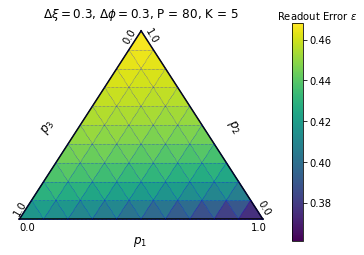

In [92]:
figure, tax = ternary.figure(scale=n)
tax.heatmap(Record_4,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(10.6,9.2,r'Readout Error $\epsilon$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \xi = 0.3$, $\Delta \phi = 0.3$, P = 80, K = 5',y=1)

### 1d).$\Delta \xi = 0.4, \Delta \phi = 0.1, P =80, K =5$ 

In [93]:
N=100
H=2100
P=80
K=5
d_xi=0.4
d_phi=0.1
th=2.8

In [94]:
Record_5 = func_run_grid_sim(n,N,H,P,K,d_xi,d_phi,th)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


d_out is 0.7915171494667326
d_out theory 0.7577628672093383
thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 1.0450690754962917
i4 intra 0.40827819382589414
part 4's 9.557853208002219e-10 3.5099193840208086e-08
i4 inter 0.0
d_out is 0.7181809485424027
d_out theory 0.7343019473190373
thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 1.6390870546429932
i4 intra 0.5108070459312166
part 4's 9.557853208002219e-10 3.5099193840208086e-08
i4 inter 0.3890681875501788
d_out is 0.7102400860219339
d_out theory 0.7108410274287363
thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 2.2331050337896947
i4 intra 0.9817048797775414
part 4's 9.557853208002219e-10 3.5099193840208086e-08
i4 inter 0.6916767778669844
d_out is 0.6822135124202791
d_out theory 0.6873801075384353
thresholds 3.135398061352784 2.93519754

thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 4.418526424217238
i4 intra 6.502495107473058
part 4's 9.557853208002219e-10 3.5099193840208086e-08
i4 inter 0.5345964927594173
d_out is 0.5850547239345427
d_out theory 0.6174853217247428
thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 5.012544403363939
i4 intra 8.83156897777743
part 4's 9.557853208002219e-10 3.5099193840208086e-08
i4 inter 0.31794814556124773
d_out is 0.5266660289310953
d_out theory 0.5940244018344418
thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 5.606562382510641
i4 intra 11.529011829822807
part 4's 9.557853208002219e-10 3.5099193840208086e-08
i4 inter 0.014840201129705168
d_out is 0.7849776156263465
d_out theory 0.7936862078306055
thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.00255513033042793
cod i

thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 2.2551714344586102
i4 intra 1.647520285762135
part 4's 9.557853208002219e-10 3.5099193840208086e-08
i4 inter 0.15344775988882817
d_out is 0.7041676617415754
d_out theory 0.7357658688906688
thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 2.8491894136053117
i4 intra 2.904149466349572
part 4's 9.557853208002219e-10 3.5099193840208086e-08
i4 inter 0.022260301694557744
d_out is 0.8141719631280702
d_out theory 0.8415839953256286
thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.37779223393887446
i4 intra 0.06740014989574936
part 4's 9.557853208002219e-10 3.5099193840208086e-08
i4 inter 0.024720982187476044
d_out is 0.8242148186686632
d_out theory 0.8181230754353276
thresholds 3.135398061352784 2.935197542821371
BELOW COD!
f is 0.002555130330427

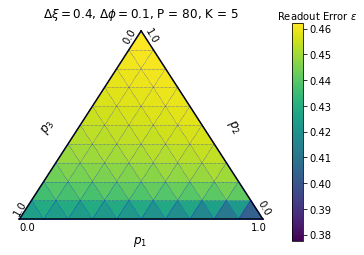

In [95]:
figure, tax = ternary.figure(scale=n)
tax.heatmap(Record_5,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(10.6,9.2,r'Readout Error $\epsilon$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \xi = 0.4$, $\Delta \phi = 0.1$, P = 80, K = 5',y=1)

### 1e).$\Delta \sigma = 0.1, \Delta \eta = 0.4, P =80, K =5$ 

In [96]:
N=100
H=2100
P=80
K=5
d_xi=0.1
d_phi=0.4
th=2.8

In [97]:
Record_6 = func_run_grid_sim(n,N,H,P,K,d_xi,d_phi,th)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


d_out is 0.6931905870809271
d_out theory 0.7577628672093383
thresholds 2.935197542821371 3.135398061352784
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.5684992068509671
i4 intra 0.08100131356906708
part 4's 2.069504677897446e-09 3.663538862340404e-09
i4 inter 0.0
d_out is 0.7286909136430233
d_out theory 0.7697373140830941
thresholds 2.935197542821371 3.135398061352784
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.6911593396951127
i4 intra 0.0775136778562404
part 4's 2.069504677897446e-09 3.663538862340404e-09
i4 inter 0.0406096627654618
d_out is 0.7807736295860983
d_out theory 0.7817117609568499
thresholds 2.935197542821371 3.135398061352784
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.8138194725392581
i4 intra 0.09945129614538721
part 4's 2.069504677897446e-09 3.663538862340404e-09
i4 inter 0.07219495602748766
d_out is 0.6810457385202102
d_out theory 0.7936862078306055
thresholds 2.935197542821371 3.135398061

d_out is 0.6679666708394378
d_out theory 0.7826877086712708
thresholds 2.935197542821371 3.135398061352784
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 1.2616819156038288
i4 intra 0.46830224935995024
part 4's 2.069504677897446e-09 3.663538862340404e-09
i4 inter 0.07547196049251051
d_out is 0.8414978723896835
d_out theory 0.7946621555450265
thresholds 2.935197542821371 3.135398061352784
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 1.3843420484479743
i4 intra 0.6206061902017269
part 4's 2.069504677897446e-09 3.663538862340404e-09
i4 inter 0.04966826556282581
d_out is 0.7707307740455053
d_out theory 0.8066366024187824
thresholds 2.935197542821371 3.135398061352784
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 1.5070021812921197
i4 intra 0.7983353850454775
part 4's 2.069504677897446e-09 3.663538862340404e-09
i4 inter 0.014840201129705168
d_out is 0.7083716477818236
d_out theory 0.6873801075384353
thresholds 2.9351975428

d_out is 0.4456225202663104
d_out theory 0.6529206884887996
thresholds 2.935197542821371 3.135398061352784
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.8081453404473704
i4 intra 0.4370464169221174
part 4's 2.069504677897446e-09 3.663538862340404e-09
i4 inter 0.04552516946299608
d_out is 0.6492822884383349
d_out theory 0.6648951353625554
thresholds 2.935197542821371 3.135398061352784
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.9308054732915159
i4 intra 0.5195547008434992
part 4's 2.069504677897446e-09 3.663538862340404e-09
i4 inter 0.022260301694557744
d_out is 0.5894922647548048
d_out theory 0.5935364279772313
thresholds 2.935197542821371 3.135398061352784
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.4187758977589287
i4 intra 0.45524931463619767
part 4's 2.069504677897446e-09 3.663538862340404e-09
i4 inter 0.053526861279233444
d_out is 0.6151832905563216
d_out theory 0.605510874850987
thresholds 2.9351975428

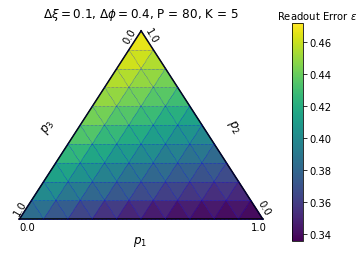

In [102]:
figure, tax = ternary.figure(scale=n)
tax.heatmap(Record_6,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(10.6,9.2,r'Readout Error $\epsilon$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \xi = 0.1$, $\Delta \phi = 0.4$, P = 80, K = 5',y=1)

### 1f). $\Delta \xi = 0.3, \Delta \phi = 0.3, P =10, K =10$ 

In [99]:
N=100
H=2100
P=10
K=10
d_xi=0.3
d_phi=0.3
th=2.8

In [100]:
Record_7 = func_run_grid_sim(n,N,H,P,K,d_xi,d_phi,th)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


d_out is 0.8090337579677669
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.1546238238510209
i4 intra 0.026969608913034248
part 4's 3.841082159503828e-09 3.841082159503828e-09
i4 inter 0.0
d_out is 0.7352304474834094
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.1717992813435178
i4 intra 0.02527169186078721
part 4's 3.841082159503828e-09 3.841082159503828e-09
i4 inter 0.010644424490438818
d_out is 0.7819414034861673
d_out theory 0.8060181487509083
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.1889747388360147
i4 intra 0.030965784269259805
part 4's 3.841082159503828e-09 3.841082159503828e-09
i4 inter 0.018923421316335676
d_out is 0.8473367418900283
d_out theory 0.806018148750908
thresholds 2.989058871028293 2.9890

d_out is 0.905258327333448
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.2920274837909961
i4 intra 0.13813113000570015
part 4's 3.841082159503828e-09 3.841082159503828e-09
i4 inter 0.02638701641333233
d_out is 0.8781659728518488
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.30920294128349296
i4 intra 0.18186405407429224
part 4's 3.841082159503828e-09 3.841082159503828e-09
i4 inter 0.01935195210360158
d_out is 0.7473752960441263
d_out theory 0.8060181487509083
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.32637839877598984
i4 intra 0.232988987603604
part 4's 3.841082159503828e-09 3.841082159503828e-09
i4 inter 0.009951460129328876
d_out is 0.7922178138067738
d_out theory 0.806018148750908
thresholds 2.9890588710

d_out is 0.9388902156554337
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.30920294128349296
i4 intra 0.15445358494445643
part 4's 3.841082159503828e-09 3.841082159503828e-09
i4 inter 0.021839817135933796
d_out is 0.8501393992501939
d_out theory 0.8060181487509082
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.32637839877598984
i4 intra 0.1781680493439324
part 4's 3.841082159503828e-09 3.841082159503828e-09
i4 inter 0.014927190193993311
d_out is 0.7716649931655606
d_out theory 0.806018148750908
thresholds 2.989058871028293 2.989058871028293
BELOW COD!
f is 0.00255513033042793
cod is 0.00255513033042793
part3 0.27485202629849914
i4 intra 0.1703163882224171
part 4's 3.841082159503828e-09 3.841082159503828e-09
i4 inter 0.02483699047769057
d_out is 0.7202829415625268
d_out theory 0.806018148750908
thresholds 2.98905887

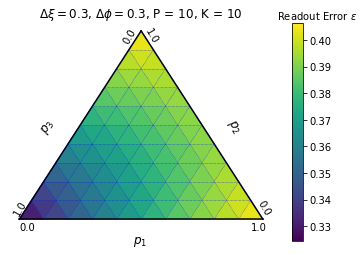

In [101]:
figure, tax = ternary.figure(scale=n)
tax.heatmap(Record_7,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(10.6,9.2,r'Readout Error $\epsilon$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \xi = 0.3$, $\Delta \phi = 0.3$, P = 10, K = 10',y=1)

## 2. Full phase diagram

In [122]:
test = np.full((2,3),-1)

In [123]:
test[0,:], value = min(Record_7.items(),key=lambda x:x[1])

In [124]:
N=100
H=2100
K=10
d_xi=0.3
d_phi=0.3
th=2.8

In [125]:
P_list = np.linspace(5,80,40,dtype=np.int)

In [126]:
delta_xis = np.linspace(0.1,0.8,40)

In [127]:
# P, delta_sigma, min_value, p1, p2 , p2 , type
Record_best = np.full((1600,7),-1.)

In [128]:
n = 10  # grid size
count = 0

for P in tqdm_notebook(P_list):
    for delta_sigma in delta_xis:
        
        if count % 20 == 0: 
            print(count)
            
        Record_temp= dict()
        
        for i,j,k in simplex_iterator(n):
            p1 = i / float(n)
            p2 = j / float(n)
            p3 = k / float(n)
            
            Record_temp[(i,j,k)] = func_het_mixing_theory(H,N,P,K,th,p1,p2,p3,ds=0.1,dc=0.)
        
        Record_best[count,0] = P
        Record_best[count,1] = delta_sigma
        Record_best[count,3:6], Record_best[count,2]  = min(Record_temp.items(),key=lambda x:x[1])
        
        
        if Record_best[count,5] == 10:
            #all mixed
            Record_best[count,6] = 0
            
        elif Record_best[count,3] > Record_best[count,4]: 
            #p1>p2
            Record_best[count,6] = 1
            
        else:
            # p2>p1
            Record_best[count,6] = 2
        
        count = count + 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0992775246504225
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.3505964493604428
i4 intra 0.4089429446271521
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1303017511036795
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.4083648341712866
i4 intra 0.6836476076789582
part 4's 3.29785

part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.6614511782085831
i4 intra 0.9906515985252461
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20465217313867054
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 0.719219563019427
i4 intra 1.3554783485088369
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1943275229852121
d_ou

part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.5294048049914546
i4 intra 1.0549362817124914
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1801544634384514
d_ou

part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.7879943502272314
i4 intra 1.4049485679901872
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1715931822504508
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6201923969931802
i4 intra 1.0309772763294696
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.10662213444704169
d_o

part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.7659815454333102
i4 intra 2.695960611667321
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.11439545483363389
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.3671060529558837
i4 intra 0.22953176487254875
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.10662213444704169
d_

part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0992775246504225
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.3505964493604428
i4 intra 0.4089429446271521
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1303017511036795
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.4083648341712866
i4 intra 0.6836476076789582
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.14891628697563372
d_out theory 0.1

part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.6614511782085831
i4 intra 0.9906515985252461
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20465217313867054
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 0.719219563019427
i4 intra 1.3554783485088369
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1943275229852121
d_ou

d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.5294048049914546
i4 intra 1.0549362817124914
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1801544634384514
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.5871731898022983
i4 intra 1.4980076816084467
part 4

part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.7879943502272314
i4 intra 1.4049485679901872
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1715931822504508
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6201923969931802
i4 intra 1.0309772763294696
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.10662213444704169
d_o

part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.7659815454333102
i4 intra 2.695960611667321
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.11439545483363389
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.3671060529558837
i4 intra 0.22953176487254875
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.10662213444704169
d_

part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0992775246504225
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.3505964493604428
i4 intra 0.4089429446271521
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1303017511036795
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.4083648341712866
i4 intra 0.6836476076789582
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.14891628697563372
d_out theory 0.1

part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.6614511782085831
i4 intra 0.9906515985252461
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20465217313867054
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 0.719219563019427
i4 intra 1.3554783485088369
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1943275229852121
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 0.7769879478302709
i4 intra 1.8036400785559723
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1715931822504508
d_out 

part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.5294048049914546
i4 intra 1.0549362817124914
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1801544634384514
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.5871731898022983
i4 intra 1.4980076816084467
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16981724428677253
d_out

part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.7879943502272314
i4 intra 1.4049485679901872
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1715931822504508
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6201923969931802
i4 intra 1.0309772763294696
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.10662213444704169
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.6779607818040241
i4 intra 1.0675544362100617
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13353912503571208
d_o

d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.7659815454333102
i4 intra 2.695960611667321
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.11439545483363389
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.3671060529558837
i4 intra 0.22953176487254875
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.10662213444704169
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.4248744377667275
i4 intra 0.2593218178849007
par

part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0992775246504225
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.3505964493604428
i4 intra 0.4089429446271521
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1303017511036795
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.4083648341712866
i4 intra 0.6836476076789582
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.14891628697563372
d_out theory 0.1

part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.6614511782085831
i4 intra 0.9906515985252461
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20465217313867054
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 0.719219563019427
i4 intra 1.3554783485088369
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1943275229852121
d_ou

d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.5294048049914546
i4 intra 1.0549362817124914
part

part3 0.7824911490287512
i4 intra 1.542590695454884
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17874289817755293
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5569208109838559
i4 intra 0.7654171549547903
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out

part3 0.47713962137909105
i4 intra 0.4721197286022437
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18674341989716553
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.5349080061899348
i4 intra 0.7502179450881697
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19709320804706487
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_

part3 0.8045039538226724
i4 intra 1.7324657194144395
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.06434744334391906
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8100071550211526
i4 intra 2.088452614495305
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0992775246504225
d_out theory 0.26653145761136465


part3 0.43037763896520786
i4 intra 0.3646943992263298
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.6614511782085831
i4 intra 0.9906515985252461
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20465217313867054
d

part3 0.2405628809372355
i4 intra 0.0896039831858852
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d

part3 0.5569208109838559
i4 intra 0.7654171549547903
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.7879943502272314
i4 intra 1.4049485679901872
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1715931822504508
d_ou

part3 0.5349080061899348
i4 intra 0.7502179450881697
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19709320804706487
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.7659815454333102
i4 intra 2.695960611667321
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.11439545483363389
d_o

part3 0.8100071550211526
i4 intra 2.088452614495305
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0992775246504225
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.3505964493604428
i4 intra 0.4089429446271521
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1303017511036795
d_out theory 0.2284555350954554
t

d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.43037763896520786
i4 intra 0.3646943992263298
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.6614511782085831
i4 intra 0.9906515985252461
par

part3 0.2405628809372355
i4 intra 0.0896039831858852
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d

part3 0.7824911490287512
i4 intra 1.542590695454884
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17874289817755293
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5569208109838559
i4 intra 0.7654171549547903
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out

part3 0.47713962137909105
i4 intra 0.4721197286022437
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18674341989716553
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.5349080061899348
i4 intra 0.7502179450881697
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19709320804706487
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_

part3 0.8045039538226724
i4 intra 1.7324657194144395
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.06434744334391906
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8100071550211526
i4 intra 2.088452614495305
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0992775246504225
d_out theory 0.26653145761136465


part3 0.7714847466317905
i4 intra 2.1880967172934507
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15014403446914446
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.43037763896520786
i4 intra 0.3646943992263298
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d

part3 0.2405628809372355
i4 intra 0.0896039831858852
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d

part3 0.7824911490287512
i4 intra 1.542590695454884
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17874289817755293
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5569208109838559
i4 intra 0.7654171549547903
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out

part3 0.47713962137909105
i4 intra 0.4721197286022437
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18674341989716553
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.5349080061899348
i4 intra 0.7502179450881697
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19709320804706487
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_

d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8045039538226724
i4 intra 1.7324657194144395
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.06434744334391906
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8100071550211526
i4 intra 2.088452614495305
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.

part3 0.7714847466317905
i4 intra 2.1880967172934507
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15014403446914446
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.43037763896520786
i4 intra 0.3646943992263298
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d

part3 0.2405628809372355
i4 intra 0.0896039831858852
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d

part3 0.5569208109838559
i4 intra 0.7654171549547903
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.7879943502272314
i4 intra 1.4049485679901872
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1715931822504508
d_ou

part3 0.47713962137909105
i4 intra 0.4721197286022437
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18674341989716553
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.5349080061899348
i4 intra 0.7502179450881697
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19709320804706487
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_

part3 0.8045039538226724
i4 intra 1.7324657194144395
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.06434744334391906
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8100071550211526
i4 intra 2.088452614495305
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0992775246504225
d_out theory 0.26653145761136465


part3 0.43037763896520786
i4 intra 0.3646943992263298
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.6614511782085831
i4 intra 0.9906515985252461
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20465217313867054
d

part3 0.2405628809372355
i4 intra 0.0896039831858852
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d

d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5569208109838559
i4 intra 0.7654171549547903
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.7879943502272314
i4 intra 1.4049485679901872
part 

part3 0.47713962137909105
i4 intra 0.4721197286022437
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18674341989716553
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.5349080061899348
i4 intra 0.7502179450881697
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19709320804706487
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_

part3 0.7467355690118285
i4 intra 1.692495006099727
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8045039538226724
i4 intra 1.7324657194144395
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.06434744334391906
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8100071550211526
i4 intra 2.088452614495305
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395

part3 0.7714847466317905
i4 intra 2.1880967172934507
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15014403446914446
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.43037763896520786
i4 intra 0.3646943992263298
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d

part3 0.2405628809372355
i4 intra 0.0896039831858852
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d

d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5569208109838559
i4 intra 0.7654171549547903
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.7879943502272314
i4 intra 1.4049485679901872
part 

part3 0.47713962137909105
i4 intra 0.4721197286022437
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18674341989716553
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.5349080061899348
i4 intra 0.7502179450881697
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19709320804706487
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_

part3 0.7467355690118285
i4 intra 1.692495006099727
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8045039538226724
i4 intra 1.7324657194144395
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.06434744334391906
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8100071550211526
i4 intra 2.088452614495305
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395

part3 0.7137163618209464
i4 intra 1.6582967838998306
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18115569192418104
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 0.7714847466317905
i4 intra 2.1880967172934507
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15014403446914446
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.43037763896520786
i4 intra 0.3646943992263298
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d

part3 0.7549751430363496
i4 intra 4.0819101673242315
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.2405628809372355
i4 intra 0.0896039831858852
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.2

part3 0.7247227642179072
i4 intra 1.1760671687542337
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19319992219203888
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 0.7824911490287512
i4 intra 1.542590695454884
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17874289817755293
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5569208109838559
i4 intra 0.7654171549547903
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_ou

part3 0.4193712365682472
i4 intra 0.27735649217986247
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16398394116596346
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.47713962137909105
i4 intra 0.4721197286022437
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18674341989716553
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.5349080061899348
i4 intra 0.7502179450881697
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19709320804706487
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498


part3 0.7467355690118285
i4 intra 1.692495006099727
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8045039538226724
i4 intra 1.7324657194144395
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.06434744334391906
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8100071550211526
i4 intra 2.088452614495305
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395

part3 0.7714847466317905
i4 intra 2.1880967172934507
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15014403446914446
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.43037763896520786
i4 intra 0.3646943992263298
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d

part3 0.2405628809372355
i4 intra 0.0896039831858852
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.045695200477303584
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d

part3 0.5569208109838559
i4 intra 0.7654171549547903
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.7879943502272314
i4 intra 1.4049485679901872
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1715931822504508
d_ou

part3 0.5349080061899348
i4 intra 0.7502179450881697
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19709320804706487
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.7659815454333102
i4 intra 2.695960611667321
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.11439545483363389
d_o

part3 0.8100071550211526
i4 intra 2.088452614495305
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0992775246504225
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.3505964493604428
i4 intra 0.4089429446271521
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1303017511036795
d_out theory 0.2284555350954554
t

part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.6614511782085831
i4 intra 0.9906515985252461
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20465217313867054
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 0.719219563019427
i4 intra 1.3554783485088369
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1943275229852121
d_ou

part3 0.29833126574807933
i4 intra 0.11600048276411709
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0974064342321388
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.3560996505589232
i4 intra 0.22573196240589363
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.13670797740567112
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4138680353697669
i4 intra 0.4187984221112148
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1635998299979007
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.4716364201806107
i4 intra 0.6951998618800809
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1780819920088275
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.5294048049914546
i4 intra 1.0549362817124914
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1801544634384514
d_ou

part3 0.5569208109838559
i4 intra 0.7654171549547903
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6146891957946998
i4 intra 0.8002975381183226
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15290323238917408
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.6724575806055436
i4 intra 0.9185129013453992
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17154290625756916
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7302259654163874
i4 intra 1.1200632446360208
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.17777288954466136
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.7879943502272314
i4 intra 1.4049485679901872
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.1715931822504508
d_ou

d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.5349080061899348
i4 intra 0.7502179450881697
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19709320804706487
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.5926763910007786
i4 intra 1.1116511416376402
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.19503330561566132
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.6504447758116225
i4 intra 1.5564193182506554
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18056371260295498
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.7082131606224664
i4 intra 2.0845224749272155
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15368442900894583
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.7659815454333102
i4 intra 2.695960611667321
part 

part3 0.8045039538226724
i4 intra 1.7324657194144395
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.06434744334391906
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8100071550211526
i4 intra 2.088452614495305
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.1772912949279114
i4 intra 0.08483883585300266
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.23505967973875525
i4 intra 0.10953855871417446
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.055843607615862656
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.29282806454959903
i4 intra 0.217573261638891
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.0992775246504225
d_out theory 0.26653145761136465


part3 0.7714847466317905
i4 intra 2.1880967172934507
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.15014403446914446
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.43037763896520786
i4 intra 0.3646943992263298
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.12185386793947621
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.48814602377605154
i4 intra 0.3961812289557418
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.16116798011122901
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5459144085868954
i4 intra 0.5110030387486985
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.18807240170167902
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6036827933977392
i4 intra 0.7091598286051999
part 4's 3.297858319836431e-08 4.030276791916617e-08
i4 inter 0.20256713271082616
d

part3 0.940514306385019
i4 intra 5.085077650955895
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.25674514358967243
i4 intra 0.0969822789458009
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.04569416941564795
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.3312391821259408
i4 intra 0.13184719293256003
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10963674161104862
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.40573322066220907
i4 intra 0.2702943496470018
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1581736917722122
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4802272591984772
i4 intra 0.512323749089126
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1913050198991387
d_out theory 0.

part3 0.7249121494678231
i4 intra 0.981777011726439
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20794637535629648
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994061880040917
i4 intra 1.3349114127305046
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20414117361432121
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 0.8739002265403597
i4 intra 1.7916280564622529
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.18493034983810883
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5626012564263548
i4 intra 0.7643619646300397
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12185111844172784
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6370952949626231
i4 intra 0.8086303271596224
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1588800558437976
d

part3 0.3924104046932773
i4 intra 0.18018505736511842
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1397939241978864
d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.46690444322954555
i4 intra 0.3205129037881248
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1829481474003838
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.5413984817658137
i4 intra 0.5644229929388138
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21069674856864415
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.6158925203020821
i4 intra 0.9119153248171854
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2230397277026674
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.6903865588383504
i4 intra 1.3629898994232397
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21997708480245357

part3 0.6849437015610278
i4 intra 1.3358795073487246
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.7594377400972963
i4 intra 1.3839092492954364
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10749756244588932
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 0.8339317786335644
i4 intra 1.535521233969831
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967
d_out theory 0.5089142239916047
thresholds 3.2331615074619044 3.135398061352784
part3 0.7461149241283643
i4 intra 1.686902350517707
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.04569416941564795
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8206089626646327
i4 intra 1.7368127821729837
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918


part3 0.60256970433315
i4 intra 0.6600316179949286
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21993421736800553
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.6770637428694185
i4 intra 1.009404639581865
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.22689446954336265
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 0.7515577814056869
i4 intra 1.4623599038964836
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21844909968448264
d_out theory 0.19502202300780772
thresholds 3.2331615074619044 3.135398061352784
part3 0.826051819941955
i4 intra 2.018897410938785
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19459810779136558
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 0.9005458584782235
i4 intra 2.6790171607087685
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_o

part3 0.717032190776214
i4 intra 2.5001511526569287
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 0.7915262293124824
i4 intra 3.2582110760289025
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 0.8660202678487506
i4 intra 4.119853242128557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06932529915406685
d_out theory 0.0
thresholds 3.2331615074619044 3.135398061352784
part3 0.940514306385019
i4 intra 5.085077650955895
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.25674514358967243
i4 intra 0.0969822789458009
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.04569416941564795
d_out theory 0.35692274695790677

part3 0.5759240723952866
i4 intra 0.5862549379013557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16933991273753585
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.650418110931555
i4 intra 0.7322248534500562
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19634595506403466
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.7249121494678231
i4 intra 0.981777011726439
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20794637535629648
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994061880040917
i4 intra 1.3349114127305046
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20414117361432121
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 0.8739002265403597
i4 intra 1.7916280564622529
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.18493034983810883
d

d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.9271914904160872
i4 intra 4.139727243023206
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.31791636615700897
i4 intra 0.1434394536697946
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.3924104046932773
i4 intra 0.18018505736511842
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1397939241978864
d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.46690444322954555
i4 intra 0.3205129037881248
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1829481474003838
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.5413984817658137
i4 intra 0.5644229929388138
p

part3 0.772760556066228
i4 intra 1.224246392590145
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15450652748908197
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 0.8472545946024962
i4 intra 1.477559930283658
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6849437015610278
i4 intra 1.3358795073487246
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.7594377400972963
i4 intra 1.3839092492954364
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10749756244588932
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 0.8339317786335644
i4 intra 1.535521233969831
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967
d_o

part3 0.45358162726061374
i4 intra 0.2720323030041038
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15979684691458018
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.5280756657968819
i4 intra 0.41424083913567494
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19756834315841137
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.60256970433315
i4 intra 0.6600316179949286
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21993421736800553
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.6770637428694185
i4 intra 1.009404639581865
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.22689446954336265
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 0.7515577814056869
i4 intra 1.4623599038964836
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21844909968448264

part3 0.5680441137036772
i4 intra 1.2947780340960322
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19257027542796343
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.6425381522399456
i4 intra 1.8456734720126393
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449
d_out theory 0.1142277675477277
thresholds 3.2331615074619044 3.135398061352784
part3 0.717032190776214
i4 intra 2.5001511526569287
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 0.7915262293124824
i4 intra 3.2582110760289025
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 0.8660202678487506
i4 intra 4.119853242128557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06932529915406685
d

part3 0.5014300338590184
i4 intra 0.5438672650803378
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12692824837679986
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.5759240723952866
i4 intra 0.5862549379013557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16933991273753585
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.650418110931555
i4 intra 0.7322248534500562
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19634595506403466
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.7249121494678231
i4 intra 0.981777011726439
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20794637535629648
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994061880040917
i4 intra 1.3349114127305046
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20414117361432121
d_

part3 0.7782034133435505
i4 intra 2.516263774134448
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.169774112064474
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 0.8526974518798189
i4 intra 3.2762043872149866
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12587733002021514
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.9271914904160872
i4 intra 4.139727243023206
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.31791636615700897
i4 intra 0.1434394536697946
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.3924104046932773
i4 intra 0.18018505736511842
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1397939241978864
d

part3 0.6982665175299596
i4 intra 1.0745150976243156
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.13826593907991547
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.772760556066228
i4 intra 1.224246392590145
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15450652748908197
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 0.8472545946024962
i4 intra 1.477559930283658
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6849437015610278
i4 intra 1.3358795073487246
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.7594377400972963
i4 intra 1.3839092492954364
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10749756244588932
d_o

part3 0.45358162726061374
i4 intra 0.2720323030041038
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15979684691458018
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.5280756657968819
i4 intra 0.41424083913567494
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19756834315841137
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.60256970433315
i4 intra 0.6600316179949286
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21993421736800553
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.6770637428694185
i4 intra 1.009404639581865
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.22689446954336265
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 0.7515577814056869
i4 intra 1.4623599038964836
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21844909968448264

part3 0.4935500751674091
i4 intra 0.8474648389071076
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.5680441137036772
i4 intra 1.2947780340960322
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19257027542796343
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.6425381522399456
i4 intra 1.8456734720126393
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449
d_out theory 0.1142277675477277
thresholds 3.2331615074619044 3.135398061352784
part3 0.717032190776214
i4 intra 2.5001511526569287
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 0.7915262293124824
i4 intra 3.2582110760289025
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_o

part3 0.8872230425092916
i4 intra 2.163657486327021
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.17753313584458447
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5014300338590184
i4 intra 0.5438672650803378
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12692824837679986
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.5759240723952866
i4 intra 0.5862549379013557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16933991273753585
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.650418110931555
i4 intra 0.7322248534500562
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19634595506403466
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.7249121494678231
i4 intra 0.981777011726439
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20794637535629648
d_o

d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 0.7782034133435505
i4 intra 2.516263774134448
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.169774112064474
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 0.8526974518798189
i4 intra 3.2762043872149866
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12587733002021514
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.9271914904160872
i4 intra 4.139727243023206
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.31791636615700897
i4 intra 0.1434394536697946
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.3924104046932773
i4 intra 0.18018505736511842
par

part3 0.6237724789936914
i4 intra 1.0283660453861683
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.6982665175299596
i4 intra 1.0745150976243156
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.13826593907991547
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.772760556066228
i4 intra 1.224246392590145
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15450652748908197
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 0.8472545946024962
i4 intra 1.477559930283658
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6849437015610278
i4 intra 1.3358795073487246
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_o

part3 0.3790875887243454
i4 intra 0.23340600960021532
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.45358162726061374
i4 intra 0.2720323030041038
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15979684691458018
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.5280756657968819
i4 intra 0.41424083913567494
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19756834315841137
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.60256970433315
i4 intra 0.6600316179949286
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21993421736800553
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.6770637428694185
i4 intra 1.009404639581865
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2268944695433626

part3 0.4935500751674091
i4 intra 0.8474648389071076
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.5680441137036772
i4 intra 1.2947780340960322
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19257027542796343
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.6425381522399456
i4 intra 1.8456734720126393
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449
d_out theory 0.1142277675477277
thresholds 3.2331615074619044 3.135398061352784
part3 0.717032190776214
i4 intra 2.5001511526569287
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 0.7915262293124824
i4 intra 3.2582110760289025
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_o

part3 0.8127290039730234
i4 intra 1.6052392895761547
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2067668546963677
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 0.8872230425092916
i4 intra 2.163657486327021
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.17753313584458447
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5014300338590184
i4 intra 0.5438672650803378
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12692824837679986
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.5759240723952866
i4 intra 0.5862549379013557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16933991273753585
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.650418110931555
i4 intra 0.7322248534500562
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19634595506403466
d_o

part3 0.7037093748072821
i4 intra 1.8599054037815943
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19826527207449574
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 0.7782034133435505
i4 intra 2.516263774134448
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.169774112064474
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 0.8526974518798189
i4 intra 3.2762043872149866
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12587733002021514
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.9271914904160872
i4 intra 4.139727243023206
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.31791636615700897
i4 intra 0.1434394536697946
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d

part3 0.8605774105714281
i4 intra 1.5629288711144653
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.17753313584458447
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6237724789936914
i4 intra 1.0283660453861683
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.6982665175299596
i4 intra 1.0745150976243156
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.13826593907991547
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.772760556066228
i4 intra 1.224246392590145
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15450652748908197
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 0.8472545946024962
i4 intra 1.477559930283658
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_

part3 0.8393746359108871
i4 intra 2.575885776818395
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16763493289931466
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.9138686744471554
i4 intra 3.337707079607498
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.3790875887243454
i4 intra 0.23340600960021532
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.45358162726061374
i4 intra 0.2720323030041038
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15979684691458018
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.5280756657968819
i4 intra 0.41424083913567494
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1975683431584

part3 0.3445619980948726
i4 intra 0.26358517671230575
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.41905603663114077
i4 intra 0.5037338864458653
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.4935500751674091
i4 intra 0.8474648389071076
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.5680441137036772
i4 intra 1.2947780340960322
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19257027542796343
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.6425381522399456
i4 intra 1.8456734720126393
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449


part3 0.738234965436755
i4 intra 1.1504033355529715
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.22059495151391395
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 0.8127290039730234
i4 intra 1.6052392895761547
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2067668546963677
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 0.8872230425092916
i4 intra 2.163657486327021
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.17753313584458447
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5014300338590184
i4 intra 0.5438672650803378
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12692824837679986
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.5759240723952866
i4 intra 0.5862549379013557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16933991273753585
d_

part3 0.6292153362710138
i4 intra 1.3071292761564224
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2113508100502805
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.7037093748072821
i4 intra 1.8599054037815943
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19826527207449574
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 0.7782034133435505
i4 intra 2.516263774134448
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.169774112064474
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 0.8526974518798189
i4 intra 3.2762043872149866
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12587733002021514
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.9271914904160872
i4 intra 4.139727243023206
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918
d_

part3 0.8605774105714281
i4 intra 1.5629288711144653
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.17753313584458447
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6237724789936914
i4 intra 1.0283660453861683
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.6982665175299596
i4 intra 1.0745150976243156
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.13826593907991547
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.772760556066228
i4 intra 1.224246392590145
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15450652748908197
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 0.8472545946024962
i4 intra 1.477559930283658
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_

part3 0.8393746359108871
i4 intra 2.575885776818395
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16763493289931466
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.9138686744471554
i4 intra 3.337707079607498
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.3790875887243454
i4 intra 0.23340600960021532
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.45358162726061374
i4 intra 0.2720323030041038
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15979684691458018
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.5280756657968819
i4 intra 0.41424083913567494
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1975683431584

part3 0.3445619980948726
i4 intra 0.26358517671230575
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.41905603663114077
i4 intra 0.5037338864458653
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.4935500751674091
i4 intra 0.8474648389071076
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.5680441137036772
i4 intra 1.2947780340960322
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19257027542796343
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.6425381522399456
i4 intra 1.8456734720126393
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449


part3 0.738234965436755
i4 intra 1.1504033355529715
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.22059495151391395
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 0.8127290039730234
i4 intra 1.6052392895761547
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2067668546963677
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 0.8872230425092916
i4 intra 2.163657486327021
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.17753313584458447
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5014300338590184
i4 intra 0.5438672650803378
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12692824837679986
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.5759240723952866
i4 intra 0.5862549379013557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16933991273753585
d_

part3 0.6292153362710138
i4 intra 1.3071292761564224
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2113508100502805
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.7037093748072821
i4 intra 1.8599054037815943
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19826527207449574
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 0.7782034133435505
i4 intra 2.516263774134448
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.169774112064474
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 0.8526974518798189
i4 intra 3.2762043872149866
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12587733002021514
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.9271914904160872
i4 intra 4.139727243023206
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918
d_

part3 0.7860833720351595
i4 intra 1.207913780401835
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.18672106454522594
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.8605774105714281
i4 intra 1.5629288711144653
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.17753313584458447
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6237724789936914
i4 intra 1.0283660453861683
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.6982665175299596
i4 intra 1.0745150976243156
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.13826593907991547
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.772760556066228
i4 intra 1.224246392590145
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15450652748908197
d

part3 0.8393746359108871
i4 intra 2.575885776818395
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16763493289931466
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.9138686744471554
i4 intra 3.337707079607498
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.3790875887243454
i4 intra 0.23340600960021532
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.45358162726061374
i4 intra 0.2720323030041038
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15979684691458018
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.5280756657968819
i4 intra 0.41424083913567494
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1975683431584

part3 0.3445619980948726
i4 intra 0.26358517671230575
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.41905603663114077
i4 intra 0.5037338864458653
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.4935500751674091
i4 intra 0.8474648389071076
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.5680441137036772
i4 intra 1.2947780340960322
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19257027542796343
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.6425381522399456
i4 intra 1.8456734720126393
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449


part3 0.738234965436755
i4 intra 1.1504033355529715
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.22059495151391395
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 0.8127290039730234
i4 intra 1.6052392895761547
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2067668546963677
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 0.8872230425092916
i4 intra 2.163657486327021
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.17753313584458447
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5014300338590184
i4 intra 0.5438672650803378
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12692824837679986
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.5759240723952866
i4 intra 0.5862549379013557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16933991273753585
d_

part3 0.5547212977347457
i4 intra 0.857935391258933
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20903072599182815
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.6292153362710138
i4 intra 1.3071292761564224
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2113508100502805
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.7037093748072821
i4 intra 1.8599054037815943
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19826527207449574
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 0.7782034133435505
i4 intra 2.516263774134448
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.169774112064474
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 0.8526974518798189
i4 intra 3.2762043872149866
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12587733002021514
d_o

part3 0.7115893334988913
i4 intra 0.9564809324168874
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.18050337121163035
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7860833720351595
i4 intra 1.207913780401835
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.18672106454522594
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.8605774105714281
i4 intra 1.5629288711144653
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.17753313584458447
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6237724789936914
i4 intra 1.0283660453861683
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.6982665175299596
i4 intra 1.0745150976243156
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1382659390799154

part3 0.6903865588383504
i4 intra 1.3629898994232397
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21997708480245357
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.7648805973746186
i4 intra 1.9176467167569764
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20150881986800265
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.8393746359108871
i4 intra 2.575885776818395
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16763493289931466
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.9138686744471554
i4 intra 3.337707079607498
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.3790875887243454
i4 intra 0.23340600960021532
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1066197286365118

part3 0.8072861466957008
i4 intra 2.081434574893117
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.19557392102233595
i4 intra 0.09403448542823423
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.27006795955860424
i4 intra 0.1270187097064287
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06932529915406685
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.3445619980948726
i4 intra 0.26358517671230575
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.41905603663114077
i4 intra 0.5037338864458653
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.228455535095

part3 0.5147528498279502
i4 intra 0.40738892984951625
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16964550976113002
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5892468883642186
i4 intra 0.5514781556896521
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2020342790462951
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.6637409269004868
i4 intra 0.7991496242574704
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21901742629722298
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.738234965436755
i4 intra 1.1504033355529715
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.22059495151391395
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 0.8127290039730234
i4 intra 1.6052392895761547
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2067668546963677


part3 0.40573322066220907
i4 intra 0.2702943496470018
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1581736917722122
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4802272591984772
i4 intra 0.512323749089126
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1913050198991387
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.5547212977347457
i4 intra 0.857935391258933
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20903072599182815
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.6292153362710138
i4 intra 1.3071292761564224
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2113508100502805
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.7037093748072821
i4 intra 1.8599054037815943
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19826527207449574
d_

part3 0.5626012564263548
i4 intra 0.7643619646300397
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12185111844172784
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6370952949626231
i4 intra 0.8086303271596224
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1588800558437976
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.7115893334988913
i4 intra 0.9564809324168874
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.18050337121163035
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.7860833720351595
i4 intra 1.207913780401835
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.18672106454522594
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 0.8605774105714281
i4 intra 1.5629288711144653
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.17753313584458447


part3 0.6158925203020821
i4 intra 0.9119153248171854
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2230397277026674
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.6903865588383504
i4 intra 1.3629898994232397
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21997708480245357
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.7648805973746186
i4 intra 1.9176467167569764
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20150881986800265
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 0.8393746359108871
i4 intra 2.575885776818395
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16763493289931466
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 0.9138686744471554
i4 intra 3.337707079607498
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967


part3 0.7461149241283643
i4 intra 1.686902350517707
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.04569416941564795
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8206089626646327
i4 intra 1.7368127821729837
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8072861466957008
i4 intra 2.081434574893117
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.19557392102233595
i4 intra 0.09403448542823423
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.27006795955860424
i4 intra 0.1270187097064287
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06932529915406685
d_out theory 0.30460738012727

part3 0.826051819941955
i4 intra 2.018897410938785
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19459810779136558
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 0.9005458584782235
i4 intra 2.6790171607087685
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.44025881129168193
i4 intra 0.3668819467370631
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12185111844172784
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.5147528498279502
i4 intra 0.40738892984951625
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16964550976113002
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.5892468883642186
i4 intra 0.5514781556896521
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2020342790462951


part3 0.940514306385019
i4 intra 5.085077650955895
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.25674514358967243
i4 intra 0.0969822789458009
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.04569416941564795
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.3312391821259408
i4 intra 0.13184719293256003
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10963674161104862
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.40573322066220907
i4 intra 0.2702943496470018
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1581736917722122
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.4802272591984772
i4 intra 0.512323749089126
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1913050198991387
d_out theory 0.

part3 0.7249121494678231
i4 intra 0.981777011726439
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20794637535629648
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994061880040917
i4 intra 1.3349114127305046
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20414117361432121
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 0.8739002265403597
i4 intra 1.7916280564622529
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.18493034983810883
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5626012564263548
i4 intra 0.7643619646300397
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12185111844172784
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.6370952949626231
i4 intra 0.8086303271596224
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1588800558437976
d

part3 0.3924104046932773
i4 intra 0.18018505736511842
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1397939241978864
d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.46690444322954555
i4 intra 0.3205129037881248
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1829481474003838
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.5413984817658137
i4 intra 0.5644229929388138
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21069674856864415
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.6158925203020821
i4 intra 0.9119153248171854
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2230397277026674
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.6903865588383504
i4 intra 1.3629898994232397
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21997708480245357

part3 0.6849437015610278
i4 intra 1.3358795073487246
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.7594377400972963
i4 intra 1.3839092492954364
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10749756244588932
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 0.8339317786335644
i4 intra 1.535521233969831
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967
d_out theory 0.5089142239916047
thresholds 3.2331615074619044 3.135398061352784
part3 0.7461149241283643
i4 intra 1.686902350517707
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.04569416941564795
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8206089626646327
i4 intra 1.7368127821729837
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918


part3 0.6770637428694185
i4 intra 1.009404639581865
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.22689446954336265
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 0.7515577814056869
i4 intra 1.4623599038964836
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21844909968448264
d_out theory 0.19502202300780772
thresholds 3.2331615074619044 3.135398061352784
part3 0.826051819941955
i4 intra 2.018897410938785
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19459810779136558
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 0.9005458584782235
i4 intra 2.6790171607087685
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.44025881129168193
i4 intra 0.3668819467370631
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12185111844172784


part3 0.717032190776214
i4 intra 2.5001511526569287
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 0.7915262293124824
i4 intra 3.2582110760289025
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 0.8660202678487506
i4 intra 4.119853242128557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06932529915406685
d_out theory 0.0
thresholds 3.2331615074619044 3.135398061352784
part3 0.940514306385019
i4 intra 5.085077650955895
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.25674514358967243
i4 intra 0.0969822789458009
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.04569416941564795
d_out theory 0.35692274695790677

part3 0.650418110931555
i4 intra 0.7322248534500562
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19634595506403466
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.7249121494678231
i4 intra 0.981777011726439
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20794637535629648
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994061880040917
i4 intra 1.3349114127305046
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20414117361432121
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 0.8739002265403597
i4 intra 1.7916280564622529
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.18493034983810883
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5626012564263548
i4 intra 0.7643619646300397
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12185111844172784
d

part3 0.31791636615700897
i4 intra 0.1434394536697946
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.3924104046932773
i4 intra 0.18018505736511842
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1397939241978864
d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.46690444322954555
i4 intra 0.3205129037881248
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1829481474003838
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.5413984817658137
i4 intra 0.5644229929388138
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21069674856864415
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.6158925203020821
i4 intra 0.9119153248171854
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.2230397277026674

part3 0.8472545946024962
i4 intra 1.477559930283658
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6849437015610278
i4 intra 1.3358795073487246
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.7594377400972963
i4 intra 1.3839092492954364
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10749756244588932
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 0.8339317786335644
i4 intra 1.535521233969831
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967
d_out theory 0.5089142239916047
thresholds 3.2331615074619044 3.135398061352784
part3 0.7461149241283643
i4 intra 1.686902350517707
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.04569416941564795
d_o

part3 0.60256970433315
i4 intra 0.6600316179949286
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21993421736800553
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.6770637428694185
i4 intra 1.009404639581865
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.22689446954336265
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 0.7515577814056869
i4 intra 1.4623599038964836
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21844909968448264
d_out theory 0.19502202300780772
thresholds 3.2331615074619044 3.135398061352784
part3 0.826051819941955
i4 intra 2.018897410938785
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19459810779136558
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 0.9005458584782235
i4 intra 2.6790171607087685
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_o

part3 0.6425381522399456
i4 intra 1.8456734720126393
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449
d_out theory 0.1142277675477277
thresholds 3.2331615074619044 3.135398061352784
part3 0.717032190776214
i4 intra 2.5001511526569287
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 0.7915262293124824
i4 intra 3.2582110760289025
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 0.8660202678487506
i4 intra 4.119853242128557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06932529915406685
d_out theory 0.0
thresholds 3.2331615074619044 3.135398061352784
part3 0.940514306385019
i4 intra 5.085077650955895
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.0
d_out theory 0.39499866947381596
th

part3 0.5759240723952866
i4 intra 0.5862549379013557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16933991273753585
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.650418110931555
i4 intra 0.7322248534500562
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19634595506403466
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.7249121494678231
i4 intra 0.981777011726439
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20794637535629648
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994061880040917
i4 intra 1.3349114127305046
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20414117361432121
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 0.8739002265403597
i4 intra 1.7916280564622529
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.18493034983810883
d

part3 0.9271914904160872
i4 intra 4.139727243023206
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.31791636615700897
i4 intra 0.1434394536697946
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.3924104046932773
i4 intra 0.18018505736511842
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1397939241978864
d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.46690444322954555
i4 intra 0.3205129037881248
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1829481474003838
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.5413984817658137
i4 intra 0.5644229929388138
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21069674856864415

part3 0.772760556066228
i4 intra 1.224246392590145
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15450652748908197
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 0.8472545946024962
i4 intra 1.477559930283658
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6849437015610278
i4 intra 1.3358795073487246
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.7594377400972963
i4 intra 1.3839092492954364
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10749756244588932
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 0.8339317786335644
i4 intra 1.535521233969831
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967
d_o

part3 0.5280756657968819
i4 intra 0.41424083913567494
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19756834315841137
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.60256970433315
i4 intra 0.6600316179949286
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21993421736800553
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.6770637428694185
i4 intra 1.009404639581865
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.22689446954336265
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 0.7515577814056869
i4 intra 1.4623599038964836
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.21844909968448264
d_out theory 0.19502202300780772
thresholds 3.2331615074619044 3.135398061352784
part3 0.826051819941955
i4 intra 2.018897410938785
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19459810779136558
d_

part3 0.5680441137036772
i4 intra 1.2947780340960322
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19257027542796343
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.6425381522399456
i4 intra 1.8456734720126393
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1848674644108449
d_out theory 0.1142277675477277
thresholds 3.2331615074619044 3.135398061352784
part3 0.717032190776214
i4 intra 2.5001511526569287
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1617590313594893
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 0.7915262293124824
i4 intra 3.2582110760289025
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1232449762738966
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 0.8660202678487506
i4 intra 4.119853242128557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06932529915406685
d

part3 0.5014300338590184
i4 intra 0.5438672650803378
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12692824837679986
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.5759240723952866
i4 intra 0.5862549379013557
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.16933991273753585
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.650418110931555
i4 intra 0.7322248534500562
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19634595506403466
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.7249121494678231
i4 intra 0.981777011726439
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20794637535629648
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994061880040917
i4 intra 1.3349114127305046
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.20414117361432121
d_

part3 0.7782034133435505
i4 intra 2.516263774134448
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.169774112064474
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 0.8526974518798189
i4 intra 3.2762043872149866
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.12587733002021514
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.9271914904160872
i4 intra 4.139727243023206
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.06657492594171918
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.31791636615700897
i4 intra 0.1434394536697946
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.3924104046932773
i4 intra 0.18018505736511842
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1397939241978864
d

part3 0.6237724789936914
i4 intra 1.0283660453861683
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.6982665175299596
i4 intra 1.0745150976243156
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.13826593907991547
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.772760556066228
i4 intra 1.224246392590145
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15450652748908197
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 0.8472545946024962
i4 intra 1.477559930283658
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.1553414938640114
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6849437015610278
i4 intra 1.3358795073487246
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.08123407896115192
d_o

part3 0.9138686744471554
i4 intra 3.337707079607498
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.11835542389638967
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.3790875887243454
i4 intra 0.23340600960021532
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.10661972863651187
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.45358162726061374
i4 intra 0.2720323030041038
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.15979684691458018
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.5280756657968819
i4 intra 0.41424083913567494
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.19756834315841137
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.60256970433315
i4 intra 0.6600316179949286
part 4's 2.7481532560926516e-08 4.169384169495455e-08
i4 inter 0.219934217368005

part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.5559962200662254
i4 intra 0.693151183337807
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22460527630104454
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.6638760979930481
i4 intra 1.1747564189622375
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.7717559759198712
i4 intra 1.8003931028115951
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26738723369171974
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8796358538466941
i4 intra 2.570061234885881
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theo

part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.0003850310909794
i4 intra 2.1050312315669233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22786983170481162
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.1082649090178023
i4 intra 2.8837012969063354
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5181429052496421
i4 intra 0.5463246798140007
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12724390109886477
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.626022783176465
i4 intra 0.6070879873450563
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18308541846742932
d_out theo

part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.936793117639471
i4 intra 2.5829122888133145
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2539980846270967
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.0446729955662941
i4 intra 3.4988623524288087
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.21382803923199944
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 1.152552873493117
i4 intra 4.558843864269233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.15226701514156465
d_out theory 0

part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7403373107620193
i4 intra 1.0910509802734274
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1465592395874291
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.8482171886888421
i4 intra 1.3003467026619742
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.16484262355647422
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 0.956097066615665
i4 intra 1.653673873275448
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1617350288301817
d_out theory 

part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.40382837766408797
i4 intra 0.24168655105867295
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5117082555909107
i4 intra 0.29794889195716534
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17889354899579274
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.6195881335177337
i4 intra 0.4982426810805854
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22951124237320158
d_out t

part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.5559962200662254
i4 intra 0.693151183337807
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22460527630104454
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.6638760979930481
i4 intra 1.1747564189622375
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.7717559759198712
i4 intra 1.8003931028115951
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26738723369171974
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8796358538466941
i4 intra 2.570061234885881
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theo

part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.0003850310909794
i4 intra 2.1050312315669233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22786983170481162
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.1082649090178023
i4 intra 2.8837012969063354
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5181429052496421
i4 intra 0.5463246798140007
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12724390109886477
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.626022783176465
i4 intra 0.6070879873450563
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18308541846742932
d_out theo

part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.936793117639471
i4 intra 2.5829122888133145
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2539980846270967
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.0446729955662941
i4 intra 3.4988623524288087
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.21382803923199944
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 1.152552873493117
i4 intra 4.558843864269233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.15226701514156465
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 1.26043275141994
i4 intra 5.762856824334581
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.06931501235579218
d_out theory 0.

part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7403373107620193
i4 intra 1.0910509802734274
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1465592395874291
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.8482171886888421
i4 intra 1.3003467026619742
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.16484262355647422
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 0.956097066615665
i4 intra 1.653673873275448
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1617350288301817
d_out theory 

part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.40382837766408797
i4 intra 0.24168655105867295
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5117082555909107
i4 intra 0.29794889195716534
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17889354899579274
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.6195881335177337
i4 intra 0.4982426810805854
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22951124237320158
d_out t

part3 0.34023646421257964
i4 intra 0.16203505676372926
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.09625940412901912
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.5559962200662254
i4 intra 0.693151183337807
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22460527630104454
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.6638760979930481
i4 intra 1.1747564189622375
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.7717559759198712
i4 intra 1.8003931028115951
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26738723369171974
d_out t

part3 0.6767453973105106
i4 intra 0.6332097248982526
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22861335580088352
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24975649313086376
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.0003850310909794
i4 intra 2.1050312315669233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22786983170481162
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.1082649090178023
i4 intra 2.8837012969063354
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out th

part3 0.6131534838590023
i4 intra 0.6992507873163956
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24616234864036313
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.936793117639471
i4 intra 2.5829122888133145
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2539980846270967
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.0446729955662941
i4 intra 3.4988623524288087
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.21382803923199944
d_out theory

part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7403373107620193
i4 intra 1.0910509802734274
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1465592395874291
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.8482171886888421
i4 intra 1.3003467026619742
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.16484262355647422
d_out theo

part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.40382837766408797
i4 intra 0.24168655105867295
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5117082555909107
i4 intra 0.29794889195716534
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17889354899579274
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.6195881335177337
i4 intra 0.4982426810805854
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22951124237320158
d_out t

part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.5559962200662254
i4 intra 0.693151183337807
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22460527630104454
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.6638760979930481
i4 intra 1.1747564189622375
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.7717559759198712
i4 intra 1.8003931028115951
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26738723369171974
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8796358538466941
i4 intra 2.570061234885881
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theo

part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24975649313086376
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.0003850310909794
i4 intra 2.1050312315669233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22786983170481162
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.1082649090178023
i4 intra 2.8837012969063354
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5181429052496421
i4 intra 0.5463246798140007
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12724390109886477
d_out the

part3 0.6131534838590023
i4 intra 0.6992507873163956
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24616234864036313
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.936793117639471
i4 intra 2.5829122888133145
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2539980846270967
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.0446729955662941
i4 intra 3.4988623524288087
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.21382803923199944
d_out theory

part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7403373107620193
i4 intra 1.0910509802734274
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1465592395874291
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.8482171886888421
i4 intra 1.3003467026619742
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.16484262355647422
d_out theo

part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.40382837766408797
i4 intra 0.24168655105867295
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5117082555909107
i4 intra 0.29794889195716534
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17889354899579274
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.6195881335177337
i4 intra 0.4982426810805854
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22951124237320158
d_out t

part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.5559962200662254
i4 intra 0.693151183337807
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22460527630104454
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.6638760979930481
i4 intra 1.1747564189622375
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.7717559759198712
i4 intra 1.8003931028115951
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26738723369171974
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8796358538466941
i4 intra 2.570061234885881
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theo

part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24975649313086376
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.0003850310909794
i4 intra 2.1050312315669233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22786983170481162
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.1082649090178023
i4 intra 2.8837012969063354
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5181429052496421
i4 intra 0.5463246798140007
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12724390109886477
d_out the

d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.936793117639471
i4 intra 2.5829122888133145
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2539980846270967
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.0446729955662941
i4 intra 3.4988623524288087
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.21382803923199944
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 1.152552873493117
i4 intra 4.558843864269233
part 4's 2.066

part3 0.7910599248960648
i4 intra 1.0342617356889467
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19627904639251983
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7403373107620193
i4 intra 1.0910509802734274
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1465592395874291
d_out the

part3 0.9939503814322481
i4 intra 2.6394693171258683
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2411249128222334
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.40382837766408797
i4 intra 0.24168655105867295
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5117082555909107
i4 intra 0.29794889195716534
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17889354899579274
d_out the

part3 0.2323565862857567
i4 intra 0.11252416581408178
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.34023646421257964
i4 intra 0.16203505676372926
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.09625940412901912
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.5559962200662254
i4 intra 0.693151183337807
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22460527630104454
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.6638760979930481
i4 intra 1.1747564189622375
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theory 0.190379

part3 0.5688655193836879
i4 intra 0.4306654524585509
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18607923977556562
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.6767453973105106
i4 intra 0.6332097248982526
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22861335580088352
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24975649313086376
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.0003850310909794
i4 intra 2.1050312315669233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22786983170481162
d_out th

part3 0.3973937280053567
i4 intra 0.1636336941097546
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.13398363117251952
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.5052736059321796
i4 intra 0.3594265166006113
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20076847925411007
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.6131534838590023
i4 intra 0.6992507873163956
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24616234864036313
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theo

part3 0.683180046969242
i4 intra 0.8272164966166818
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1699120850713838
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.7910599248960648
i4 intra 1.0342617356889467
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19627904639251983
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theo

part3 0.8860705035054253
i4 intra 1.865300218419019
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26798755687408404
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939503814322481
i4 intra 2.6394693171258683
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2411249128222334
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.40382837766408797
i4 intra 0.24168655105867295
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theor

part3 0.2323565862857567
i4 intra 0.11252416581408178
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.34023646421257964
i4 intra 0.16203505676372926
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.09625940412901912
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.5559962200662254
i4 intra 0.693151183337807
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22460527630104454
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.6638760979930481
i4 intra 1.1747564189622375
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theory 0.190379

part3 0.6767453973105106
i4 intra 0.6332097248982526
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22861335580088352
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24975649313086376
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.0003850310909794
i4 intra 2.1050312315669233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22786983170481162
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.1082649090178023
i4 intra 2.8837012969063354
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out th

d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.6131534838590023
i4 intra 0.6992507873163956
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24616234864036313
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.936793117639471
i4 intra 2.5829122888133145
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2539980846270967
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.0446729955662941
i4 intra 3.4988623524288087
part 4's 2.06

part3 0.7910599248960648
i4 intra 1.0342617356889467
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19627904639251983
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7403373107620193
i4 intra 1.0910509802734274
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1465592395874291
d_out the

part3 0.9939503814322481
i4 intra 2.6394693171258683
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2411249128222334
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.40382837766408797
i4 intra 0.24168655105867295
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5117082555909107
i4 intra 0.29794889195716534
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17889354899579274
d_out the

part3 0.34023646421257964
i4 intra 0.16203505676372926
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.09625940412901912
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.5559962200662254
i4 intra 0.693151183337807
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22460527630104454
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.6638760979930481
i4 intra 1.1747564189622375
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.7717559759198712
i4 intra 1.8003931028115951
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26738723369171974
d_out t

d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24975649313086376
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.0003850310909794
i4 intra 2.1050312315669233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22786983170481162
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.1082649090178023
i4 intra 2.8837012969063354
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5181429052496421
i4 intra 0.5463246798140007
part 4's 

part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 0.936793117639471
i4 intra 2.5829122888133145
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2539980846270967
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.0446729955662941
i4 intra 3.4988623524288087
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.21382803923199944
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 1.152552873493117
i4 intra 4.558843864269233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.15226701514156465
d_out theory 0

part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7403373107620193
i4 intra 1.0910509802734274
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1465592395874291
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.8482171886888421
i4 intra 1.3003467026619742
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.16484262355647422
d_out theo

part3 0.9939503814322481
i4 intra 2.6394693171258683
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2411249128222334
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.40382837766408797
i4 intra 0.24168655105867295
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5117082555909107
i4 intra 0.29794889195716534
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17889354899579274
d_out the

part3 0.2323565862857567
i4 intra 0.11252416581408178
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.34023646421257964
i4 intra 0.16203505676372926
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.09625940412901912
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.5559962200662254
i4 intra 0.693151183337807
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22460527630104454
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.6638760979930481
i4 intra 1.1747564189622375
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25669174434405095
d_out theory 0.190379

part3 0.5688655193836879
i4 intra 0.4306654524585509
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18607923977556562
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.6767453973105106
i4 intra 0.6332097248982526
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22861335580088352
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24975649313086376
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.0003850310909794
i4 intra 2.1050312315669233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22786983170481162
d_out th

part3 0.3973937280053567
i4 intra 0.1636336941097546
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.13398363117251952
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.5052736059321796
i4 intra 0.3594265166006113
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20076847925411007
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.6131534838590023
i4 intra 0.6992507873163956
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24616234864036313
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theo

part3 0.683180046969242
i4 intra 0.8272164966166818
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1699120850713838
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.7910599248960648
i4 intra 1.0342617356889467
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19627904639251983
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theo

part3 0.7781906255786024
i4 intra 1.235162567937098
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2734592222305971
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.8860705035054253
i4 intra 1.865300218419019
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26798755687408404
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939503814322481
i4 intra 2.6394693171258683
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2411249128222334
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0

part3 0.8546518383475732
i4 intra 1.749837870742279
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.06931501235579218
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8039292242135274
i4 intra 2.072774553441921
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.2323565862857567
i4 intra 0.11252416581408178
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.34023646421257964
i4 intra 0.16203505676372926
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.09625940412901912
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresh

part3 0.460985641456865
i4 intra 0.37215262824377693
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12215414505491018
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.5688655193836879
i4 intra 0.4306654524585509
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18607923977556562
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.6767453973105106
i4 intra 0.6332097248982526
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22861335580088352
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24975649313086376
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out th

part3 0.3973937280053567
i4 intra 0.1636336941097546
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.13398363117251952
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.5052736059321796
i4 intra 0.3594265166006113
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20076847925411007
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.6131534838590023
i4 intra 0.6992507873163956
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24616234864036313
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theo

part3 0.683180046969242
i4 intra 0.8272164966166818
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1699120850713838
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.7910599248960648
i4 intra 1.0342617356889467
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19627904639251983
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theo

part3 0.7781906255786024
i4 intra 1.235162567937098
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2734592222305971
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.8860705035054253
i4 intra 1.865300218419019
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26798755687408404
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939503814322481
i4 intra 2.6394693171258683
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2411249128222334
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0

part3 0.8546518383475732
i4 intra 1.749837870742279
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.06931501235579218
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8039292242135274
i4 intra 2.072774553441921
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.2323565862857567
i4 intra 0.11252416581408178
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.34023646421257964
i4 intra 0.16203505676372926
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.09625940412901912
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresh

part3 0.460985641456865
i4 intra 0.37215262824377693
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12215414505491018
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.5688655193836879
i4 intra 0.4306654524585509
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18607923977556562
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.6767453973105106
i4 intra 0.6332097248982526
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22861335580088352
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24975649313086376
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out th

part3 0.3973937280053567
i4 intra 0.1636336941097546
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.13398363117251952
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.5052736059321796
i4 intra 0.3594265166006113
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20076847925411007
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.6131534838590023
i4 intra 0.6992507873163956
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24616234864036313
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2727771513268565
d_out theo

part3 0.683180046969242
i4 intra 0.8272164966166818
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1699120850713838
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.7910599248960648
i4 intra 1.0342617356889467
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19627904639251983
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6324574328351962
i4 intra 1.0257867061098085
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theo

part3 0.8860705035054253
i4 intra 1.865300218419019
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26798755687408404
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939503814322481
i4 intra 2.6394693171258683
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2411249128222334
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.2097101372858938
i4 intra 4.619901859214349
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.40382837766408797
i4 intra 0.24168655105867295
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1068848769230464
d_out theor

part3 0.8039292242135274
i4 intra 2.072774553441921
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.2323565862857567
i4 intra 0.11252416581408178
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.34023646421257964
i4 intra 0.16203505676372926
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.09625940412901912
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.4481163421394025
i4 intra 0.3555773959383044
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.17112782956270067
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.5559962200662254
i4 intra 0.693151183337807
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22460527630104454
d_out theory 0.2284555350954554
thresh

part3 0.5688655193836879
i4 intra 0.4306654524585509
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18607923977556562
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.6767453973105106
i4 intra 0.6332097248982526
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22861335580088352
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24975649313086376
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 0.8925051531641566
i4 intra 1.4703926144524386
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24950865176550652
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.0003850310909794
i4 intra 2.1050312315669233
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22786983170481162
d_out th

d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.3973937280053567
i4 intra 0.1636336941097546
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.13398363117251952
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.5052736059321796
i4 intra 0.3594265166006113
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20076847925411007
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.6131534838590023
i4 intra 0.6992507873163956
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24616234864036313
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.7210333617858253
i4 intra 1.1831065062571078
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2701652393312786
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 0.8289132397126482
i4 intra 1.8109936734227472
part 4's 

part3 0.5753001690424192
i4 intra 0.7642027057693447
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12215414505491018
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.683180046969242
i4 intra 0.8272164966166818
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1699120850713838
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.7910599248960648
i4 intra 1.0342617356889467
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19627904639251983
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.0068196807497107
i4 intra 1.8804465585082597
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18484003294877913
d_out theo

part3 0.6703107476517794
i4 intra 0.7490563656801043
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25753990889177253
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.7781906255786024
i4 intra 1.235162567937098
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2734592222305971
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.8860705035054253
i4 intra 1.865300218419019
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26798755687408404
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939503814322481
i4 intra 2.6394693171258683
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2411249128222334
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.101830259359071
i4 intra 3.557669864057644
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19287129007504517
d_out theory 0

part3 0.7467719604207503
i4 intra 1.6800726299460969
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.045807804395591324
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8546518383475732
i4 intra 1.749837870742279
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.06931501235579218
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8039292242135274
i4 intra 2.072774553441921
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.2323565862857567
i4 intra 0.11252416581408178
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.34023646421257964
i4 intra 0.16203505676372926
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.09625940412901912
d_out theory 0.30460738012727395
thres

d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 1.158987523151848
i4 intra 3.6601833500715992
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1617350288301817
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.460985641456865
i4 intra 0.37215262824377693
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12215414505491018
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.5688655193836879
i4 intra 0.4306654524585509
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18607923977556562
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.6767453973105106
i4 intra 0.6332097248982526
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22861335580088352
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.7846252752373337
i4 intra 0.9797854455628817
part 4's 2

part3 1.3111553655539858
i4 intra 7.0890482454322985
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.2895138500785338
i4 intra 0.11187231984382547
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.045807804395591324
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.3973937280053567
i4 intra 0.1636336941097546
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.13398363117251952
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.5052736059321796
i4 intra 0.3594265166006113
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20076847925411007
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.6131534838590023
i4 intra 0.6992507873163956
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.24616234864036313
d_out theory 0.242694

part3 1.0575422948837565
i4 intra 2.290455699718555
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19254170098831158
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5753001690424192
i4 intra 0.7642027057693447
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12215414505491018
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.683180046969242
i4 intra 0.8272164966166818
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1699120850713838
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.7910599248960648
i4 intra 1.0342617356889467
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.19627904639251983
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 0.8989398028228878
i4 intra 1.3853384229861394
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.20125502901831824
d_out theory

part3 0.5624308697249566
i4 intra 0.40698161164803837
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.22022961685761042
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.6703107476517794
i4 intra 0.7490563656801043
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.25753990889177253
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.7781906255786024
i4 intra 1.235162567937098
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2734592222305971
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 0.8860705035054253
i4 intra 1.865300218419019
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.26798755687408404
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939503814322481
i4 intra 2.6394693171258683
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2411249128222334
d_out theo

part3 0.905374452481619
i4 intra 1.6101376440201218
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12322668863251943
d_out theory 0.5089142239916047
thresholds 3.2331615074619044 3.135398061352784
part3 0.7467719604207503
i4 intra 1.6800726299460969
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.045807804395591324
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8546518383475732
i4 intra 1.749837870742279
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.06931501235579218
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8039292242135274
i4 intra 2.072774553441921
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.2323565862857567
i4 intra 0.11252416581408178
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.0
d_out theory 0.34268330264318314
threshold

part3 0.9432277672982023
i4 intra 1.963312737800411
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.2530184503334024
d_out theory 0.19502202300780772
thresholds 3.2331615074619044 3.135398061352784
part3 1.0511076452250252
i4 intra 2.739732319823542
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.21807222892946082
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 1.158987523151848
i4 intra 3.6601833500715992
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.1617350288301817
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.460985641456865
i4 intra 0.37215262824377693
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.12215414505491018
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.5688655193836879
i4 intra 0.4306654524585509
part 4's 2.06624064537252e-08 4.341947751808443e-08
i4 inter 0.18607923977556562
d_out theory

d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 1.3990628319874376
i4 intra 5.823776599222882
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 1.5402853447936447
i4 intra 7.365392183311853
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12317418752859971
d_out theory 0.0
thresholds 3.2331615074619044 3.135398061352784
part3 1.6815078575998512
i4 intra 9.091458513086357
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.32254928893123863
i4 intra 0.12685042834496743
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.045997791672632043
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.4637718017374454
i4 intra 0.19548162237348274
part 4's 1.6598482814079

part3 0.6768380393112657
i4 intra 0.6288027805422423
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.19637018591739416
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.8180605521174724
i4 intra 0.8923710219515133
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23759668662667716
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.9592830649236792
i4 intra 1.340390009046317
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.251451145662938
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 1.1005055777298858
i4 intra 1.972859741826654
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23793356302617674
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 1.2417280905360926
i4 intra 2.789780220292523
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.19704393871639328

part3 1.5935519041870996
i4 intra 7.384758019280787
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.3758158483246937
i4 intra 0.16659690828513116
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.08177385186245698
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.5170383611309004
i4 intra 0.2378496777374521
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1831177813325388
d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.6582608739371072
i4 intra 0.4935531928753061
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2570896691295986
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994833867433139
i4 intra 0.9337074536986928
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.303689515253636

part3 0.9245936709043825
i4 intra 1.3781236885963863
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1734927075440273
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 1.065816183710589
i4 intra 1.8313858265388012
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.16551690852177034
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6954152046854241
i4 intra 1.3285470664212007
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.08177385186245698
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.8366377174916309
i4 intra 1.4155292884163557
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.11762700715698546
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 0.9778602302978374
i4 intra 1.6869622560970439
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1261081207784

part3 0.5703049205243554
i4 intra 0.3241925558869018
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1977569810102977
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.7115274333305622
i4 intra 0.5825176464485614
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2608137397780986
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.8527499461367689
i4 intra 1.0252934826957538
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2964984568728772
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939724589429758
i4 intra 1.6525200646284794
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3048111322946337
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 1.1351949717491825
i4 intra 2.464197392246737
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2857517660433681

part3 0.8341727807626105
i4 intra 1.5018217197223198
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.9753952935688172
i4 intra 2.30563432106916
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.34215052091277687
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 1.1166178063750238
i4 intra 3.293897668101535
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658
d_out theory 0.1142277675477277
thresholds 3.2331615074619044 3.135398061352784
part3 1.2578403191812306
i4 intra 4.466611760819441
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.28740643756673256
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 1.3990628319874376
i4 intra 5.823776599222882
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727


part3 1.1884615311426374
i4 intra 2.6050013948768895
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.24650871812128428
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.3296840439488442
i4 intra 3.603751043604487
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18916218116773756
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.535615526505059
i4 intra 0.5496852848185042
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.127771643535089
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.6768380393112657
i4 intra 0.6288027805422423
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.19637018591739416
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.8180605521174724
i4 intra 0.8923710219515133
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23759668662667716

d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 1.1698843657684792
i4 intra 3.3053987777990526
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30897151757334446
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.311106878574686
i4 intra 4.480734445940763
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.25699832603455225
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 1.4523293913808928
i4 intra 5.84052085976801
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.17765309282273806
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 1.5935519041870996
i4 intra 7.384758019280787
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.3758158483246937
i4 intra 0.16659690828513116
p

part3 1.153772137123341
i4 intra 2.1989918146039615
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18916218116773756
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6421486452919691
i4 intra 1.0249516497681548
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.10732818056947474
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7833711580981758
i4 intra 1.1093122963395041
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.15409646489326212
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.9245936709043825
i4 intra 1.3781236885963863
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1734927075440273
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 1.065816183710589
i4 intra 1.8313858265388012
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.16551690852177

part3 1.364373437968141
i4 intra 4.538831953847567
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21636848301956488
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.5055959507743477
i4 intra 5.90123994309862
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12610812077849173
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.4290824077181487
i4 intra 0.25031821101077517
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.10732818056947474
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5703049205243554
i4 intra 0.3241925558869018
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1977569810102977
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.7115274333305622
i4 intra 0.5825176464485614
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2608137397780

part3 0.41050524234399033
i4 intra 0.19708838979499368
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12317418752859971
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.551727755150197
i4 intra 0.4475487540852362
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.6929502679564038
i4 intra 0.8824598640610115
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.28740643756673256
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.8341727807626105
i4 intra 1.5018217197223198
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.9753952935688172
i4 intra 2.30563432106916
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3421505209127

part3 0.6235714799178105
i4 intra 0.45451025682183194
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.20217444920524955
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.7647939927240173
i4 intra 0.7154569228072971
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2543160789437915
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.9060165055302241
i4 intra 1.1608543344782953
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.27908566700931114
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 1.0472390183364308
i4 intra 1.7907024918348267
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2764832134018088
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.1884615311426374
i4 intra 2.6050013948768895
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.246508718121

part3 0.4637718017374454
i4 intra 0.19548162237348274
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.15825685017197286
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.6049943145436522
i4 intra 0.44856356208753095
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.24314386699829144
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.7462168273498587
i4 intra 0.886096247487112
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30065884215158795
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.8874393401560655
i4 intra 1.5080796785722261
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.33080177563186225
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 1.0286618529622722
i4 intra 2.3145138553428724
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3335726674

part3 1.2417280905360926
i4 intra 2.789780220292523
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.19704393871639328
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5888820858985139
i4 intra 0.7653310559005894
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12266077779368542
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.7301045987047207
i4 intra 0.8470701270481332
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18034419114673167
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.8713271115109275
i4 intra 1.1132599438812099
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21065556282675582
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 1.0125496243171341
i4 intra 1.5639005063998193
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2135948928337

part3 0.6582608739371072
i4 intra 0.4935531928753061
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2570896691295986
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994833867433139
i4 intra 0.9337074536986928
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30368951525363613
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.9407058995495207
i4 intra 1.5583124602076124
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.32291731970465165
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 1.0819284123557276
i4 intra 2.3673682124020643
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3147730824826448
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 1.2231509251619341
i4 intra 3.3608747102820504
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.279256803587

part3 0.8366377174916309
i4 intra 1.4155292884163557
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.11762700715698546
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 0.9778602302978374
i4 intra 1.6869622560970439
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12610812077849173
d_out theory 0.5089142239916047
thresholds 3.2331615074619044 3.135398061352784
part3 0.7486817640788792
i4 intra 1.6761173058597267
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.045997791672632043
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8899042768850858
i4 intra 1.7657211032786873
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8019483234723342
i4 intra 2.0676623680837327
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theo

part3 0.9939724589429758
i4 intra 1.6525200646284794
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3048111322946337
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 1.1351949717491825
i4 intra 2.464197392246737
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2857517660433681
d_out theory 0.19502202300780772
thresholds 3.2331615074619044 3.135398061352784
part3 1.2764174845553888
i4 intra 3.460325465550528
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23932035811908034
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 1.4176399973615958
i4 intra 4.64090428453985
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.16551690852177034
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.4823489671116038
i4 intra 0.3780143365218996
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1226607777936854

part3 1.1166178063750238
i4 intra 3.293897668101535
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658
d_out theory 0.1142277675477277
thresholds 3.2331615074619044 3.135398061352784
part3 1.2578403191812306
i4 intra 4.466611760819441
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.28740643756673256
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 1.3990628319874376
i4 intra 5.823776599222882
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 1.5402853447936447
i4 intra 7.365392183311853
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12317418752859971
d_out theory 0.0
thresholds 3.2331615074619044 3.135398061352784
part3 1.6815078575998512
i4 intra 9.091458513086357
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.39499866947381

part3 1.3296840439488442
i4 intra 3.603751043604487
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18916218116773756
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.535615526505059
i4 intra 0.5496852848185042
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.127771643535089
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.6768380393112657
i4 intra 0.6288027805422423
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.19637018591739416
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.8180605521174724
i4 intra 0.8923710219515133
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23759668662667716
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.9592830649236792
i4 intra 1.340390009046317
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.251451145662938
d_

d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 1.1698843657684792
i4 intra 3.3053987777990526
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30897151757334446
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.311106878574686
i4 intra 4.480734445940763
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.25699832603455225
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 1.4523293913808928
i4 intra 5.84052085976801
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.17765309282273806
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 1.5935519041870996
i4 intra 7.384758019280787
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.3758158483246937
i4 intra 0.16659690828513116
p

d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6421486452919691
i4 intra 1.0249516497681548
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.10732818056947474
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7833711580981758
i4 intra 1.1093122963395041
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.15409646489326212
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.9245936709043825
i4 intra 1.3781236885963863
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1734927075440273
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 1.065816183710589
i4 intra 1.8313858265388012
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.16551690852177034
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6954152046854241
i4 intra 1.3285470664212007

part3 1.5055959507743477
i4 intra 5.90123994309862
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12610812077849173
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.4290824077181487
i4 intra 0.25031821101077517
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.10732818056947474
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5703049205243554
i4 intra 0.3241925558869018
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1977569810102977
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.7115274333305622
i4 intra 0.5825176464485614
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2608137397780986
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.8527499461367689
i4 intra 1.0252934826957538
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2964984568728

part3 0.41050524234399033
i4 intra 0.19708838979499368
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12317418752859971
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.551727755150197
i4 intra 0.4475487540852362
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.6929502679564038
i4 intra 0.8824598640610115
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.28740643756673256
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.8341727807626105
i4 intra 1.5018217197223198
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.9753952935688172
i4 intra 2.30563432106916
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3421505209127

d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.7647939927240173
i4 intra 0.7154569228072971
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2543160789437915
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.9060165055302241
i4 intra 1.1608543344782953
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.27908566700931114
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 1.0472390183364308
i4 intra 1.7907024918348267
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2764832134018088
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.1884615311426374
i4 intra 2.6050013948768895
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.24650871812128428
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.3296840439488442
i4 intra 3.603751043604487


part3 0.6049943145436522
i4 intra 0.44856356208753095
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.24314386699829144
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.7462168273498587
i4 intra 0.886096247487112
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30065884215158795
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.8874393401560655
i4 intra 1.5080796785722261
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.33080177563186225
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 1.0286618529622722
i4 intra 2.3145138553428724
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.33357266743911446
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 1.1698843657684792
i4 intra 3.3053987777990526
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30897151757

part3 0.7301045987047207
i4 intra 0.8470701270481332
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18034419114673167
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.8713271115109275
i4 intra 1.1132599438812099
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21065556282675582
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 1.0125496243171341
i4 intra 1.5639005063998193
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21359489283375774
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.153772137123341
i4 intra 2.1989918146039615
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18916218116773756
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6421486452919691
i4 intra 1.0249516497681548
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.10732818056

d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 1.0819284123557276
i4 intra 2.3673682124020643
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3147730824826448
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 1.2231509251619341
i4 intra 3.3608747102820504
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2792568035876159
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.364373437968141
i4 intra 4.538831953847567
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21636848301956488
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.5055959507743477
i4 intra 5.90123994309862
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12610812077849173
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.4290824077181487
i4 intra 0.25031821101077517


part3 0.8899042768850858
i4 intra 1.7657211032786873
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8019483234723342
i4 intra 2.0676623680837327
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.26928272953778354
i4 intra 0.13107877119028405
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.41050524234399033
i4 intra 0.19708838979499368
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12317418752859971
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.551727755150197
i4 intra 0.4475487540852362
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727
d_out theory 0.26653145

part3 1.4176399973615958
i4 intra 4.64090428453985
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.16551690852177034
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.4823489671116038
i4 intra 0.3780143365218996
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12266077779368542
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.6235714799178105
i4 intra 0.45451025682183194
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.20217444920524955
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.7647939927240173
i4 intra 0.7154569228072971
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2543160789437915
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.9060165055302241
i4 intra 1.1608543344782953
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2790856670093

d_out theory 0.0
thresholds 3.2331615074619044 3.135398061352784
part3 1.6815078575998512
i4 intra 9.091458513086357
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.32254928893123863
i4 intra 0.12685042834496743
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.045997791672632043
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.4637718017374454
i4 intra 0.19548162237348274
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.15825685017197286
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.6049943145436522
i4 intra 0.44856356208753095
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.24314386699829144
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.7462168273498587
i4 intra 0.886096247487112
part 4's 1.6598482814079

d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.9592830649236792
i4 intra 1.340390009046317
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.251451145662938
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 1.1005055777298858
i4 intra 1.972859741826654
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23793356302617674
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 1.2417280905360926
i4 intra 2.789780220292523
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.19704393871639328
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5888820858985139
i4 intra 0.7653310559005894
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12266077779368542
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.7301045987047207
i4 intra 0.8470701270481332
par

part3 1.5935519041870996
i4 intra 7.384758019280787
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.3758158483246937
i4 intra 0.16659690828513116
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.08177385186245698
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.5170383611309004
i4 intra 0.2378496777374521
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1831177813325388
d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.6582608739371072
i4 intra 0.4935531928753061
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2570896691295986
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994833867433139
i4 intra 0.9337074536986928
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.303689515253636

part3 0.9245936709043825
i4 intra 1.3781236885963863
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1734927075440273
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 1.065816183710589
i4 intra 1.8313858265388012
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.16551690852177034
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6954152046854241
i4 intra 1.3285470664212007
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.08177385186245698
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.8366377174916309
i4 intra 1.4155292884163557
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.11762700715698546
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 0.9778602302978374
i4 intra 1.6869622560970439
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1261081207784

part3 0.5703049205243554
i4 intra 0.3241925558869018
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1977569810102977
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.7115274333305622
i4 intra 0.5825176464485614
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2608137397780986
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.8527499461367689
i4 intra 1.0252934826957538
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2964984568728772
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939724589429758
i4 intra 1.6525200646284794
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3048111322946337
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 1.1351949717491825
i4 intra 2.464197392246737
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2857517660433681

part3 0.8341727807626105
i4 intra 1.5018217197223198
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.9753952935688172
i4 intra 2.30563432106916
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.34215052091277687
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 1.1166178063750238
i4 intra 3.293897668101535
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658
d_out theory 0.1142277675477277
thresholds 3.2331615074619044 3.135398061352784
part3 1.2578403191812306
i4 intra 4.466611760819441
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.28740643756673256
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 1.3990628319874376
i4 intra 5.823776599222882
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727


d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.1884615311426374
i4 intra 2.6050013948768895
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.24650871812128428
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.3296840439488442
i4 intra 3.603751043604487
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18916218116773756
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.535615526505059
i4 intra 0.5496852848185042
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.127771643535089
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.6768380393112657
i4 intra 0.6288027805422423
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.19637018591739416
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.8180605521174724
i4 intra 0.8923710219515133
pa

part3 0.8874393401560655
i4 intra 1.5080796785722261
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.33080177563186225
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 1.0286618529622722
i4 intra 2.3145138553428724
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.33357266743911446
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 1.1698843657684792
i4 intra 3.3053987777990526
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30897151757334446
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.311106878574686
i4 intra 4.480734445940763
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.25699832603455225
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 1.4523293913808928
i4 intra 5.84052085976801
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.177653092822738

d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 1.0125496243171341
i4 intra 1.5639005063998193
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21359489283375774
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.153772137123341
i4 intra 2.1989918146039615
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18916218116773756
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6421486452919691
i4 intra 1.0249516497681548
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.10732818056947474
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7833711580981758
i4 intra 1.1093122963395041
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.15409646489326212
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.9245936709043825
i4 intra 1.378123688596386

d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 1.2231509251619341
i4 intra 3.3608747102820504
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2792568035876159
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.364373437968141
i4 intra 4.538831953847567
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21636848301956488
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.5055959507743477
i4 intra 5.90123994309862
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12610812077849173
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.4290824077181487
i4 intra 0.25031821101077517
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.10732818056947474
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5703049205243554
i4 intra 0.3241925558869018

d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8019483234723342
i4 intra 2.0676623680837327
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.26928272953778354
i4 intra 0.13107877119028405
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.41050524234399033
i4 intra 0.19708838979499368
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12317418752859971
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.551727755150197
i4 intra 0.4475487540852362
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.6929502679564038
i4 intra 0.8824598640610115
part 4's 1.65984828140799

part3 0.4823489671116038
i4 intra 0.3780143365218996
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12266077779368542
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.6235714799178105
i4 intra 0.45451025682183194
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.20217444920524955
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.7647939927240173
i4 intra 0.7154569228072971
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2543160789437915
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.9060165055302241
i4 intra 1.1608543344782953
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.27908566700931114
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 1.0472390183364308
i4 intra 1.7907024918348267
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.27648321340

d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.32254928893123863
i4 intra 0.12685042834496743
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.045997791672632043
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.4637718017374454
i4 intra 0.19548162237348274
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.15825685017197286
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.6049943145436522
i4 intra 0.44856356208753095
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.24314386699829144
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.7462168273498587
i4 intra 0.886096247487112
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30065884215158795
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.8874393401560655
i4 intra 1.50807967

d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 1.2417280905360926
i4 intra 2.789780220292523
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.19704393871639328
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5888820858985139
i4 intra 0.7653310559005894
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12266077779368542
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.7301045987047207
i4 intra 0.8470701270481332
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18034419114673167
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.8713271115109275
i4 intra 1.1132599438812099
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21065556282675582
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 1.0125496243171341
i4 intra 1.563900506399819

d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.6582608739371072
i4 intra 0.4935531928753061
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2570896691295986
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994833867433139
i4 intra 0.9337074536986928
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30368951525363613
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.9407058995495207
i4 intra 1.5583124602076124
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.32291731970465165
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 1.0819284123557276
i4 intra 2.3673682124020643
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3147730824826448
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 1.2231509251619341
i4 intra 3.360874710282050

d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.8366377174916309
i4 intra 1.4155292884163557
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.11762700715698546
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 0.9778602302978374
i4 intra 1.6869622560970439
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12610812077849173
d_out theory 0.5089142239916047
thresholds 3.2331615074619044 3.135398061352784
part3 0.7486817640788792
i4 intra 1.6761173058597267
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.045997791672632043
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8899042768850858
i4 intra 1.7657211032786873
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8019483234723342
i4 intra 2.06766236808373

part3 0.8527499461367689
i4 intra 1.0252934826957538
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2964984568728772
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939724589429758
i4 intra 1.6525200646284794
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3048111322946337
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 1.1351949717491825
i4 intra 2.464197392246737
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2857517660433681
d_out theory 0.19502202300780772
thresholds 3.2331615074619044 3.135398061352784
part3 1.2764174845553888
i4 intra 3.460325465550528
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23932035811908034
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 1.4176399973615958
i4 intra 4.64090428453985
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.16551690852177034

part3 1.1166178063750238
i4 intra 3.293897668101535
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658
d_out theory 0.1142277675477277
thresholds 3.2331615074619044 3.135398061352784
part3 1.2578403191812306
i4 intra 4.466611760819441
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.28740643756673256
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 1.3990628319874376
i4 intra 5.823776599222882
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 1.5402853447936447
i4 intra 7.365392183311853
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12317418752859971
d_out theory 0.0
thresholds 3.2331615074619044 3.135398061352784
part3 1.6815078575998512
i4 intra 9.091458513086357
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.39499866947381

part3 0.535615526505059
i4 intra 0.5496852848185042
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.127771643535089
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.6768380393112657
i4 intra 0.6288027805422423
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.19637018591739416
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.8180605521174724
i4 intra 0.8923710219515133
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23759668662667716
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.9592830649236792
i4 intra 1.340390009046317
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.251451145662938
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 1.1005055777298858
i4 intra 1.972859741826654
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23793356302617674
d_

d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.311106878574686
i4 intra 4.480734445940763
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.25699832603455225
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 1.4523293913808928
i4 intra 5.84052085976801
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.17765309282273806
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 1.5935519041870996
i4 intra 7.384758019280787
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.3758158483246937
i4 intra 0.16659690828513116
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.08177385186245698
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.5170383611309004
i4 intra 0.2378496777374521
pa

d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7833711580981758
i4 intra 1.1093122963395041
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.15409646489326212
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.9245936709043825
i4 intra 1.3781236885963863
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1734927075440273
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 1.065816183710589
i4 intra 1.8313858265388012
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.16551690852177034
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6954152046854241
i4 intra 1.3285470664212007
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.08177385186245698
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.8366377174916309
i4 intra 1.4155292884163557

part3 0.4290824077181487
i4 intra 0.25031821101077517
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.10732818056947474
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5703049205243554
i4 intra 0.3241925558869018
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1977569810102977
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.7115274333305622
i4 intra 0.5825176464485614
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2608137397780986
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.8527499461367689
i4 intra 1.0252934826957538
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2964984568728772
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939724589429758
i4 intra 1.6525200646284794
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3048111322946

part3 0.551727755150197
i4 intra 0.4475487540852362
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.6929502679564038
i4 intra 0.8824598640610115
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.28740643756673256
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.8341727807626105
i4 intra 1.5018217197223198
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.9753952935688172
i4 intra 2.30563432106916
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.34215052091277687
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 1.1166178063750238
i4 intra 3.293897668101535
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658

d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 0.9060165055302241
i4 intra 1.1608543344782953
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.27908566700931114
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 1.0472390183364308
i4 intra 1.7907024918348267
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2764832134018088
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.1884615311426374
i4 intra 2.6050013948768895
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.24650871812128428
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.3296840439488442
i4 intra 3.603751043604487
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18916218116773756
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.535615526505059
i4 intra 0.5496852848185042


d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.7462168273498587
i4 intra 0.886096247487112
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30065884215158795
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.8874393401560655
i4 intra 1.5080796785722261
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.33080177563186225
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 1.0286618529622722
i4 intra 2.3145138553428724
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.33357266743911446
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 1.1698843657684792
i4 intra 3.3053987777990526
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30897151757334446
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.311106878574686
i4 intra 4.480734445940763


d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.7301045987047207
i4 intra 0.8470701270481332
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18034419114673167
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.8713271115109275
i4 intra 1.1132599438812099
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21065556282675582
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 1.0125496243171341
i4 intra 1.5639005063998193
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21359489283375774
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.153772137123341
i4 intra 2.1989918146039615
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18916218116773756
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6421486452919691
i4 intra 1.02495164976815

part3 0.7994833867433139
i4 intra 0.9337074536986928
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30368951525363613
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 0.9407058995495207
i4 intra 1.5583124602076124
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.32291731970465165
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 1.0819284123557276
i4 intra 2.3673682124020643
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3147730824826448
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 1.2231509251619341
i4 intra 3.3608747102820504
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2792568035876159
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.364373437968141
i4 intra 4.538831953847567
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.216368483019564

part3 0.9778602302978374
i4 intra 1.6869622560970439
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12610812077849173
d_out theory 0.5089142239916047
thresholds 3.2331615074619044 3.135398061352784
part3 0.7486817640788792
i4 intra 1.6761173058597267
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.045997791672632043
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.8899042768850858
i4 intra 1.7657211032786873
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8019483234723342
i4 intra 2.0676623680837327
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.26928272953778354
i4 intra 0.13107877119028405
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.342683302

part3 1.1351949717491825
i4 intra 2.464197392246737
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2857517660433681
d_out theory 0.19502202300780772
thresholds 3.2331615074619044 3.135398061352784
part3 1.2764174845553888
i4 intra 3.460325465550528
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23932035811908034
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 1.4176399973615958
i4 intra 4.64090428453985
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.16551690852177034
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.4823489671116038
i4 intra 0.3780143365218996
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12266077779368542
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.6235714799178105
i4 intra 0.45451025682183194
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.20217444920524

part3 1.3990628319874376
i4 intra 5.823776599222882
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 1.5402853447936447
i4 intra 7.365392183311853
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12317418752859971
d_out theory 0.0
thresholds 3.2331615074619044 3.135398061352784
part3 1.6815078575998512
i4 intra 9.091458513086357
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.32254928893123863
i4 intra 0.12685042834496743
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.045997791672632043
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.4637718017374454
i4 intra 0.19548162237348274
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.15825685017197286
d_out theory 0.318846

d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.8180605521174724
i4 intra 0.8923710219515133
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23759668662667716
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 0.9592830649236792
i4 intra 1.340390009046317
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.251451145662938
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 1.1005055777298858
i4 intra 1.972859741826654
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.23793356302617674
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 1.2417280905360926
i4 intra 2.789780220292523
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.19704393871639328
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.5888820858985139
i4 intra 0.7653310559005894
par

d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 1.5935519041870996
i4 intra 7.384758019280787
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.3758158483246937
i4 intra 0.16659690828513116
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.08177385186245698
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.5170383611309004
i4 intra 0.2378496777374521
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1831177813325388
d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.6582608739371072
i4 intra 0.4935531928753061
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2570896691295986
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.7994833867433139
i4 intra 0.9337074536986928


d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 0.9245936709043825
i4 intra 1.3781236885963863
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1734927075440273
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 1.065816183710589
i4 intra 1.8313858265388012
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.16551690852177034
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.6954152046854241
i4 intra 1.3285470664212007
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.08177385186245698
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.8366377174916309
i4 intra 1.4155292884163557
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.11762700715698546
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 0.9778602302978374
i4 intra 1.6869622560970439


part3 0.4290824077181487
i4 intra 0.25031821101077517
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.10732818056947474
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.5703049205243554
i4 intra 0.3241925558869018
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.1977569810102977
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.7115274333305622
i4 intra 0.5825176464485614
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2608137397780986
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.8527499461367689
i4 intra 1.0252934826957538
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2964984568728772
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 0.9939724589429758
i4 intra 1.6525200646284794
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3048111322946

part3 0.551727755150197
i4 intra 0.4475487540852362
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21897633338417727
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.6929502679564038
i4 intra 0.8824598640610115
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.28740643756673256
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 0.8341727807626105
i4 intra 1.5018217197223198
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 0.9753952935688172
i4 intra 2.30563432106916
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.34215052091277687
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 1.1166178063750238
i4 intra 3.293897668101535
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3284645000762658

part3 0.9060165055302241
i4 intra 1.1608543344782953
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.27908566700931114
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 1.0472390183364308
i4 intra 1.7907024918348267
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2764832134018088
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.1884615311426374
i4 intra 2.6050013948768895
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.24650871812128428
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.3296840439488442
i4 intra 3.603751043604487
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18916218116773756
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.535615526505059
i4 intra 0.5496852848185042
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.127771643535089

d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 0.8874393401560655
i4 intra 1.5080796785722261
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.33080177563186225
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 1.0286618529622722
i4 intra 2.3145138553428724
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.33357266743911446
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 1.1698843657684792
i4 intra 3.3053987777990526
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.30897151757334446
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.311106878574686
i4 intra 4.480734445940763
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.25699832603455225
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 1.4523293913808928
i4 intra 5.84052085976801


d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.8713271115109275
i4 intra 1.1132599438812099
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21065556282675582
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 1.0125496243171341
i4 intra 1.5639005063998193
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21359489283375774
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.153772137123341
i4 intra 2.1989918146039615
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.18916218116773756
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6421486452919691
i4 intra 1.0249516497681548
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.10732818056947474
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.7833711580981758
i4 intra 1.1093122963395

part3 1.0819284123557276
i4 intra 2.3673682124020643
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.3147730824826448
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 1.2231509251619341
i4 intra 3.3608747102820504
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.2792568035876159
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.364373437968141
i4 intra 4.538831953847567
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.21636848301956488
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.5055959507743477
i4 intra 5.90123994309862
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.12610812077849173
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.4290824077181487
i4 intra 0.25031821101077517
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.107328180569474

part3 0.8899042768850858
i4 intra 1.7657211032786873
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0709358179379016
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8019483234723342
i4 intra 2.0676623680837327
part 4's 1.6598482814079973e-08 4.4447886746010324e-08
i4 inter 0.0
160
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.3062800089354219
i4 intra 0.1496655662675865
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.0
d_out theory 0.34268330264318314
thresholds 3.2331615074619044 3.135398061352784
part3 0.4808237358969868
i4 intra 0.2321600604099881
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.1500793913235842
d_out theory 0.30460738012727395
thresholds 3.2331615074619044 3.135398061352784
part3 0.6553674628585516
i4 intra 0.5395097693442273
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.26680780679748306
d_out theory 0.26653145761

d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 1.6763969905850526
i4 intra 5.621404462379698
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.16801585033675198
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.504027866160324
i4 intra 0.3841690748799646
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.12326835810733447
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.678571593121889
i4 intra 0.478636814323773
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2181040904920878
d_out theory 0.3615651573861683
thresholds 3.2331615074619044 3.135398061352784
part3 0.8531153200834539
i4 intra 0.7979597685594192
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2795888470271558
d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 1.0276590470450186
i4 intra 1.342137937586903
part 4'

d_out theory 0.0
thresholds 3.2331615074619044 3.135398061352784
part3 2.0517172785510707
i4 intra 11.093095173324295
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.35571697324164747
i4 intra 0.1418722006157222
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.04622563429025043
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.5302607002032124
i4 intra 0.22736000608347548
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.18249411087912693
d_out theory 0.31884682444199747
thresholds 3.2331615074619044 3.135398061352784
part3 0.7048044271647771
i4 intra 0.5377030263430664
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.28541161161831796
d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.8793481541263418
i4 intra 1.0729012613944948
part 4's 1.3900583927256671e-

d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 1.251639738312809
i4 intra 2.2924691818689906
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2523979551972102
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 1.4261834652743737
i4 intra 3.289351091805501
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.20001886944851427
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.6029017947727752
i4 intra 0.767097800405989
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.12326835810733447
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.7774455217343399
i4 intra 0.8675521625005009
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.1904822610226723
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.9519892486959047
i4 intra 1.1928617393868506
part 4

part3 0.5796976645094379
i4 intra 0.26683944696026873
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.20463646725905835
d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.7542413914710027
i4 intra 0.5801757785452114
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2937430532635418
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.9287851184325674
i4 intra 1.1183673249219914
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.34949866341833974
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 1.1033288453941321
i4 intra 1.8814140860906101
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.37190329772345243
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 1.2778725723556974
i4 intra 2.869316062051065
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.36095695617887963

d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 1.050863177308356
i4 intra 1.7648816910275056
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.12801207644704915
d_out theory 0.5089142239916047
thresholds 3.2331615074619044 3.135398061352784
part3 0.751212687691452
i4 intra 1.67358710271982
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.04622563429025043
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.9257564146530165
i4 intra 1.7830213987903871
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.07200679300146515
d_out theory 0.5231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 0.8006496519976775
i4 intra 2.0643091938977083
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.0
d_out theory 0.3807592251590924
thresholds 3.2331615074619044 3.135398061352784
part3 0.3062800089354219
i4 intra 0.1496655662675865
part 4's 1.39005839272

part3 1.3273095366619228
i4 intra 2.9650482434325713
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.3175832904443691
d_out theory 0.19502202300780772
thresholds 3.2331615074619044 3.135398061352784
part3 1.5018532636234874
i4 intra 4.1807987455102165
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.25947505831540324
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 1.6763969905850526
i4 intra 5.621404462379698
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.16801585033675198
d_out theory 0.4377170024179867
thresholds 3.2331615074619044 3.135398061352784
part3 0.504027866160324
i4 intra 0.3841690748799646
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.12326835810733447
d_out theory 0.39964107990207753
thresholds 3.2331615074619044 3.135398061352784
part3 0.678571593121889
i4 intra 0.478636814323773
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2181040904920878
d_o

part3 1.7026298246279405
i4 intra 7.105567533578255
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.26680780679748306
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 1.8771735515895056
i4 intra 8.986903746055356
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.1500793913235842
d_out theory 0.0
thresholds 3.2331615074619044 3.135398061352784
part3 2.0517172785510707
i4 intra 11.093095173324295
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.0
d_out theory 0.39499866947381596
thresholds 3.2331615074619044 3.135398061352784
part3 0.35571697324164747
i4 intra 0.1418722006157222
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.04622563429025043
d_out theory 0.35692274695790677
thresholds 3.2331615074619044 3.135398061352784
part3 0.5302607002032124
i4 intra 0.22736000608347548
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.18249411087912693
d_out theory 0.3188468244419

d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 1.0770960113512442
i4 intra 1.5204424867243174
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2714260650962207
d_out theory 0.2996527566690734
thresholds 3.2331615074619044 3.135398061352784
part3 1.251639738312809
i4 intra 2.2924691818689906
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2523979551972102
d_out theory 0.26157683415316413
thresholds 3.2331615074619044 3.135398061352784
part3 1.4261834652743737
i4 intra 3.289351091805501
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.20001886944851427
d_out theory 0.4661958910474339
thresholds 3.2331615074619044 3.135398061352784
part3 0.6029017947727752
i4 intra 0.767097800405989
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.12326835810733447
d_out theory 0.4281199685315247
thresholds 3.2331615074619044 3.135398061352784
part3 0.7774455217343399
i4 intra 0.8675521625005009
part 4'

part3 0.405153937547873
i4 intra 0.17835833016716374
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.08217890540488966
d_out theory 0.3711621912726303
thresholds 3.2331615074619044 3.135398061352784
part3 0.5796976645094379
i4 intra 0.26683944696026873
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.20463646725905835
d_out theory 0.3330862687567211
thresholds 3.2331615074619044 3.135398061352784
part3 0.7542413914710027
i4 intra 0.5801757785452114
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2937430532635418
d_out theory 0.29501034624081185
thresholds 3.2331615074619044 3.135398061352784
part3 0.9287851184325674
i4 intra 1.1183673249219914
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.34949866341833974
d_out theory 0.2569344237249026
thresholds 3.2331615074619044 3.135398061352784
part3 1.1033288453941321
i4 intra 1.8814140860906101
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.37190329772345243

d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.7017757233852264
i4 intra 1.3271445067452372
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.08217890540488966
d_out theory 0.45659885716097187
thresholds 3.2331615074619044 3.135398061352784
part3 0.8763194503467913
i4 intra 1.4335854914904527
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.1217709788508121
d_out theory 0.4185229346450626
thresholds 3.2331615074619044 3.135398061352784
part3 1.050863177308356
i4 intra 1.7648816910275056
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.12801207644704915
d_out theory 0.5089142239916047
thresholds 3.2331615074619044 3.135398061352784
part3 0.751212687691452
i4 intra 1.67358710271982
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.04622563429025043
d_out theory 0.47083830147569544
thresholds 3.2331615074619044 3.135398061352784
part3 0.9257564146530165
i4 intra 1.7830213987903871
part 4

d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.9782220827387929
i4 intra 1.2081128836527941
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.33374682715324455
d_out theory 0.2711738680396262
thresholds 3.2331615074619044 3.135398061352784
part3 1.152765809700358
i4 intra 1.9741529561467641
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.34234054672364955
d_out theory 0.23309794552371696
thresholds 3.2331615074619044 3.135398061352784
part3 1.3273095366619228
i4 intra 2.9650482434325713
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.3175832904443691
d_out theory 0.19502202300780772
thresholds 3.2331615074619044 3.135398061352784
part3 1.5018532636234874
i4 intra 4.1807987455102165
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.25947505831540324
d_out theory 0.15694610049189847
thresholds 3.2331615074619044 3.135398061352784
part3 1.6763969905850526
i4 intra 5.621404462379698
par

part3 1.178998643743246
i4 intra 2.8106901848979704
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.41688719812106717
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 1.3535423707048109
i4 intra 4.017460752999561
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.4002117101962245
d_out theory 0.1142277675477277
thresholds 3.2331615074619044 3.135398061352784
part3 1.528086097666376
i4 intra 5.449086535892987
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.35018524642169646
d_out theory 0.07615184503181849
thresholds 3.2331615074619044 3.135398061352784
part3 1.7026298246279405
i4 intra 7.105567533578255
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.26680780679748306
d_out theory 0.038075922515909244
thresholds 3.2331615074619044 3.135398061352784
part3 1.8771735515895056
i4 intra 8.986903746055356
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.1500793913235842
d_ou

part3 1.551290227929713
i4 intra 4.32380373342038
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.1920181146705737
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5534648304665497
i4 intra 0.5534936900413238
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.12840453969514007
d_out theory 0.4138805242168011
thresholds 3.2331615074619044 3.135398061352784
part3 0.7280085574281145
i4 intra 0.650954740810484
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2094293573451857
d_out theory 0.3758046017008918
thresholds 3.2331615074619044 3.135398061352784
part3 0.9025522843896793
i4 intra 0.9732710063714819
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.25710319914554586
d_out theory 0.3377286791849826
thresholds 3.2331615074619044 3.135398061352784
part3 1.0770960113512442
i4 intra 1.5204424867243174
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2714260650962207
d_out t

part3 1.4029793350110364
i4 intra 4.027627255299807
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.36357185607822856
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.5775230619726015
i4 intra 5.462246349518585
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.29973447756899274
d_out theory 0.09039128934654207
thresholds 3.2331615074619044 3.135398061352784
part3 1.7520667889341661
i4 intra 7.121720658529204
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.20254612321007168
d_out theory 0.05231536683063283
thresholds 3.2331615074619044 3.135398061352784
part3 1.9266105158957312
i4 intra 9.006050182331657
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.07200679300146515
d_out theory 0.4092381137885396
thresholds 3.2331615074619044 3.135398061352784
part3 0.405153937547873
i4 intra 0.17835833016716374
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.08217890540488966
d_

part3 0.6523387590790007
i4 intra 1.0249814059739597
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.10785981334391766
d_out theory 0.44235941284624825
thresholds 3.2331615074619044 3.135398061352784
part3 0.8268824860405656
i4 intra 1.1284290793938236
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.16126280152454783
d_out theory 0.404283490330339
thresholds 3.2331615074619044 3.135398061352784
part3 1.0014262130021303
i4 intra 1.4567319676055248
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.18131481385549256
d_out theory 0.36620756781442976
thresholds 3.2331615074619044 3.135398061352784
part3 1.1759699399636951
i4 intra 2.009890070609064
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.16801585033675198
d_out theory 0.4946747796768811
thresholds 3.2331615074619044 3.135398061352784
part3 0.7017757233852264
i4 intra 1.3271445067452372
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.08217890540488966


d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.8015037532403917
i4 intra 7.18215327868346
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.12801207644704915
d_out theory 0.42347755810326315
thresholds 3.2331615074619044 3.135398061352784
part3 0.45459090185409856
i4 intra 0.25912395492191115
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.10785981334391766
d_out theory 0.38540163558735385
thresholds 3.2331615074619044 3.135398061352784
part3 0.6291346288156633
i4 intra 0.35059838304036794
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.21650646046337868
d_out theory 0.34732571307144466
thresholds 3.2331615074619044 3.135398061352784
part3 0.8036783557772282
i4 intra 0.6669280259506623
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.29180213173315434
d_out theory 0.3092497905555355
thresholds 3.2331615074619044 3.135398061352784
part3 0.9782220827387929
i4 intra 1.208112883652794

part3 0.6553674628585516
i4 intra 0.5395097693442273
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.26680780679748306
d_out theory 0.26653145761136465
thresholds 3.2331615074619044 3.135398061352784
part3 0.8299111898201165
i4 intra 1.071714693070304
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.35018524642169646
d_out theory 0.2284555350954554
thresholds 3.2331615074619044 3.135398061352784
part3 1.0044549167816812
i4 intra 1.8287748315882189
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.4002117101962245
d_out theory 0.1903796125795462
thresholds 3.2331615074619044 3.135398061352784
part3 1.178998643743246
i4 intra 2.8106901848979704
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.41688719812106717
d_out theory 0.15230369006363698
thresholds 3.2331615074619044 3.135398061352784
part3 1.3535423707048109
i4 intra 4.017460752999561
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.4002117101962245
d_o

d_out theory 0.32348923487025905
thresholds 3.2331615074619044 3.135398061352784
part3 1.0276590470450186
i4 intra 1.342137937586903
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.3077226277125382
d_out theory 0.2854133123543498
thresholds 3.2331615074619044 3.135398061352784
part3 1.2022027740065835
i4 intra 2.111171321406225
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.30250543254823553
d_out theory 0.24733738983844056
thresholds 3.2331615074619044 3.135398061352784
part3 1.3767465009681485
i4 intra 3.105059920017383
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.2639372615342473
d_out theory 0.2092614673225313
thresholds 3.2331615074619044 3.135398061352784
part3 1.551290227929713
i4 intra 4.32380373342038
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.1920181146705737
d_out theory 0.4519564467327103
thresholds 3.2331615074619044 3.135398061352784
part3 0.5534648304665497
i4 intra 0.5534936900413238
part 4's 1

d_out theory 0.2807709019260882
thresholds 3.2331615074619044 3.135398061352784
part3 0.8793481541263418
i4 intra 1.0729012613944948
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.35497813650782367
d_out theory 0.24269497941017903
thresholds 3.2331615074619044 3.135398061352784
part3 1.0538918810879068
i4 intra 1.8329547112377618
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.39119368554764417
d_out theory 0.2046190568942698
thresholds 3.2331615074619044 3.135398061352784
part3 1.2284356080494716
i4 intra 2.817863375872865
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.3940582587377791
d_out theory 0.16654313437836055
thresholds 3.2331615074619044 3.135398061352784
part3 1.4029793350110364
i4 intra 4.027627255299807
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.36357185607822856
d_out theory 0.1284672118624513
thresholds 3.2331615074619044 3.135398061352784
part3 1.5775230619726015
i4 intra 5.462246349518585
part 

part3 0.7774455217343399
i4 intra 0.8675521625005009
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.1904822610226723
d_out theory 0.39004404601561543
thresholds 3.2331615074619044 3.135398061352784
part3 0.9519892486959047
i4 intra 1.1928617393868506
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.22434518808832482
d_out theory 0.3519681234997062
thresholds 3.2331615074619044 3.135398061352784
part3 1.1265329756574693
i4 intra 1.7430265310650377
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.224857139304292
d_out theory 0.31389220098379694
thresholds 3.2331615074619044 3.135398061352784
part3 1.3010767026190344
i4 intra 2.5180465375350627
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.1920181146705737
d_out theory 0.48043533536215743
thresholds 3.2331615074619044 3.135398061352784
part3 0.6523387590790007
i4 intra 1.0249814059739597
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.10785981334391766
d

part3 1.1033288453941321
i4 intra 1.8814140860906101
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.37190329772345243
d_out theory 0.21885850120899336
thresholds 3.2331615074619044 3.135398061352784
part3 1.2778725723556974
i4 intra 2.869316062051065
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.36095695617887963
d_out theory 0.18078257869308414
thresholds 3.2331615074619044 3.135398061352784
part3 1.452416299317262
i4 intra 4.082073252803359
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.3166596387846215
d_out theory 0.1427066561771749
thresholds 3.2331615074619044 3.135398061352784
part3 1.626960026278827
i4 intra 5.519685658347489
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.239011345540678
d_out theory 0.10463073366126566
thresholds 3.2331615074619044 3.135398061352784
part3 1.8015037532403917
i4 intra 7.18215327868346
part 4's 1.3900583927256671e-08 4.513061219984347e-08
i4 inter 0.12801207644704915
d_out t

KeyboardInterrupt: 

In [ ]:
plt.hist(Record_best[:,6])
plt.show()

In [ ]:
np.savetxt('Record_best.txt',Record_best,fmt='%.5f')

In [ ]:
w0 = np.argwhere(Record_best[:,6] == 0).reshape(-1)
w1 = np.argwhere(Record_best[:,6] == 1).reshape(-1)
w2 = np.argwhere(Record_best[:,6] == 2).reshape(-1)

In [ ]:
plt.plot(Record_best[w0,0]/20,Record_best[w0,1]/0.3, 'o', c='tab:red', label = r'$p3=1.0$, all mixed')
plt.plot(Record_best[w1,0]/20,Record_best[w1,1]/0.3, 'o', c='tab:orange', label = r'$p3\ne1, p1>p2$')
plt.plot(Record_best[w2,0]/20,Record_best[w2,1]/0.3, 'o', c='tab:green', label = r'$p3\ne1, p2>p1$')
plt.xlabel(r'$\frac{P}{K}$')
plt.ylabel(r'$\frac{\Delta \sigma}{\Delta \eta}$')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Optimal fraction phase diagram, with $K=20, \Delta \eta=0.3$')
plt.legend()
plt.show()